# CITE-seq reference mapping with totalVI

With totalVI, we can train a reference model that can be used for mapping new query data. Here we dive into this functionality.

If you use totalVI, please consider citing:

- Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch
import umap
from scvi.model import TOTALVI
from sklearn.ensemble import RandomForestClassifier

## Building a reference model

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

This dataset was filtered as described in the scvi-tools manuscript (low quality cells, doublets, lowly expressed genes, etc.).

```{important}
Here we use the argument `mask_protein_batches=5`. What this does is treats the protein data in 5/24 of the batches in this dataset as missing. This will help totalVI integrate query data that has a subset of the proteins measured in this dataset or no proteins at all (i.e., just scRNA-seq data).
```

In [5]:
adata = scvi.data.pbmc_seurat_v4_cite_seq(
    save_path=save_dir.name,
    mask_protein_batches=5,
)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO     Downloading file at /tmp/tmpkyrakh_v/pbmc_seurat_v4.h5ad                                                  


Downloading...:   0%|          | 0/1002579.0 [00:00<?, ?it/s]

Downloading...:   0%|          | 17/1002579.0 [00:00<2:21:51, 117.78it/s]

Downloading...:   0%|          | 52/1002579.0 [00:00<1:30:31, 184.57it/s]

Downloading...:   0%|          | 87/1002579.0 [00:00<1:21:30, 204.99it/s]

Downloading...:   0%|          | 209/1002579.0 [00:00<37:55, 440.58it/s] 

Downloading...:   0%|          | 452/1002579.0 [00:00<19:30, 856.44it/s]

Downloading...:   0%|          | 922/1002579.0 [00:00<10:21, 1612.34it/s]

Downloading...:   0%|          | 1600/1002579.0 [00:01<06:41, 2493.69it/s]

Downloading...:   0%|          | 1846/1002579.0 [00:01<07:26, 2243.08it/s]

Downloading...:   0%|          | 3096/1002579.0 [00:01<04:03, 4113.04it/s]

Downloading...:   0%|          | 4194/1002579.0 [00:01<03:17, 5061.58it/s]

Downloading...:   1%|          | 5341/1002579.0 [00:01<02:51, 5807.75it/s]

Downloading...:   1%|          | 6521/1002579.0 [00:01<02:36, 6347.00it/s]

Downloading...:   1%|          | 7717/1002579.0 [00:01<02:26, 6787.27it/s]

Downloading...:   1%|          | 8831/1002579.0 [00:02<02:26, 6774.46it/s]

Downloading...:   1%|          | 10125/1002579.0 [00:02<02:12, 7480.88it/s]

Downloading...:   1%|          | 10994/1002579.0 [00:02<02:23, 6933.39it/s]

Downloading...:   1%|          | 11878/1002579.0 [00:02<02:31, 6546.54it/s]

Downloading...:   1%|▏         | 12779/1002579.0 [00:02<02:37, 6299.79it/s]

Downloading...:   1%|▏         | 13680/1002579.0 [00:02<02:38, 6251.67it/s]

Downloading...:   1%|▏         | 14598/1002579.0 [00:03<02:40, 6142.05it/s]

Downloading...:   2%|▏         | 15532/1002579.0 [00:03<02:42, 6056.07it/s]

Downloading...:   2%|▏         | 16466/1002579.0 [00:03<02:42, 6070.39it/s]

Downloading...:   2%|▏         | 17400/1002579.0 [00:03<02:39, 6184.79it/s]

Downloading...:   2%|▏         | 18366/1002579.0 [00:03<02:40, 6114.92it/s]

Downloading...:   2%|▏         | 19317/1002579.0 [00:03<02:37, 6252.31it/s]

Downloading...:   2%|▏         | 20300/1002579.0 [00:03<02:39, 6160.59it/s]

Downloading...:   2%|▏         | 21266/1002579.0 [00:04<02:35, 6319.20it/s]

Downloading...:   2%|▏         | 22249/1002579.0 [00:04<02:34, 6350.16it/s]

Downloading...:   2%|▏         | 23249/1002579.0 [00:04<02:35, 6288.06it/s]

Downloading...:   2%|▏         | 24232/1002579.0 [00:04<02:30, 6481.71it/s]

Downloading...:   3%|▎         | 25231/1002579.0 [00:04<02:30, 6495.73it/s]

Downloading...:   3%|▎         | 26247/1002579.0 [00:04<02:32, 6388.02it/s]

Downloading...:   3%|▎         | 27263/1002579.0 [00:05<02:31, 6424.57it/s]

Downloading...:   3%|▎         | 28262/1002579.0 [00:05<02:26, 6649.60it/s]

Downloading...:   3%|▎         | 29294/1002579.0 [00:05<02:30, 6487.23it/s]

Downloading...:   3%|▎         | 30310/1002579.0 [00:05<02:25, 6686.97it/s]

Downloading...:   3%|▎         | 31342/1002579.0 [00:05<02:27, 6584.98it/s]

Downloading...:   3%|▎         | 32375/1002579.0 [00:05<02:27, 6595.80it/s]

Downloading...:   3%|▎         | 33407/1002579.0 [00:05<02:25, 6638.88it/s]

Downloading...:   3%|▎         | 34439/1002579.0 [00:06<02:23, 6749.46it/s]

Downloading...:   4%|▎         | 35471/1002579.0 [00:06<02:21, 6827.86it/s]

Downloading...:   4%|▎         | 36503/1002579.0 [00:06<02:09, 7457.19it/s]

Downloading...:   4%|▎         | 37486/1002579.0 [00:06<02:01, 7958.78it/s]

Downloading...:   4%|▍         | 38307/1002579.0 [00:06<02:05, 7659.26it/s]

Downloading...:   4%|▍         | 39089/1002579.0 [00:06<02:21, 6816.60it/s]

Downloading...:   4%|▍         | 39792/1002579.0 [00:06<02:37, 6107.57it/s]

Downloading...:   4%|▍         | 40681/1002579.0 [00:07<02:33, 6277.39it/s]

Downloading...:   4%|▍         | 41730/1002579.0 [00:07<02:28, 6465.27it/s]

Downloading...:   4%|▍         | 42778/1002579.0 [00:07<02:27, 6509.32it/s]

Downloading...:   4%|▍         | 43827/1002579.0 [00:07<02:23, 6692.94it/s]

Downloading...:   4%|▍         | 44876/1002579.0 [00:07<02:21, 6784.17it/s]

Downloading...:   5%|▍         | 45941/1002579.0 [00:07<02:24, 6600.94it/s]

Downloading...:   5%|▍         | 46989/1002579.0 [00:07<02:21, 6754.08it/s]

Downloading...:   5%|▍         | 48038/1002579.0 [00:08<02:20, 6784.33it/s]

Downloading...:   5%|▍         | 49086/1002579.0 [00:08<02:19, 6845.17it/s]

Downloading...:   5%|▌         | 50135/1002579.0 [00:08<02:16, 6964.59it/s]

Downloading...:   5%|▌         | 51200/1002579.0 [00:08<02:21, 6725.03it/s]

Downloading...:   5%|▌         | 52248/1002579.0 [00:08<02:19, 6807.66it/s]

Downloading...:   5%|▌         | 53297/1002579.0 [00:08<02:18, 6845.60it/s]

Downloading...:   5%|▌         | 54346/1002579.0 [00:09<02:17, 6900.11it/s]

Downloading...:   6%|▌         | 55394/1002579.0 [00:09<02:15, 7000.24it/s]

Downloading...:   6%|▌         | 56443/1002579.0 [00:09<02:16, 6955.73it/s]

Downloading...:   6%|▌         | 57491/1002579.0 [00:09<02:06, 7497.60it/s]

Downloading...:   6%|▌         | 58458/1002579.0 [00:09<01:58, 7991.32it/s]

Downloading...:   6%|▌         | 59280/1002579.0 [00:09<02:05, 7534.66it/s]

Downloading...:   6%|▌         | 60049/1002579.0 [00:09<02:21, 6673.55it/s]

Downloading...:   6%|▌         | 60738/1002579.0 [00:09<02:35, 6070.90it/s]

Downloading...:   6%|▌         | 61702/1002579.0 [00:10<02:24, 6490.49it/s]

Downloading...:   6%|▋         | 62751/1002579.0 [00:10<02:22, 6610.93it/s]

Downloading...:   6%|▋         | 63799/1002579.0 [00:10<02:19, 6730.29it/s]

Downloading...:   6%|▋         | 64848/1002579.0 [00:10<02:07, 7356.37it/s]

Downloading...:   7%|▋         | 65814/1002579.0 [00:10<01:58, 7902.59it/s]

Downloading...:   7%|▋         | 66628/1002579.0 [00:10<02:06, 7394.17it/s]

Downloading...:   7%|▋         | 67386/1002579.0 [00:10<02:21, 6593.55it/s]

Downloading...:   7%|▋         | 68068/1002579.0 [00:11<02:36, 5989.02it/s]

Downloading...:   7%|▋         | 69075/1002579.0 [00:11<02:27, 6331.02it/s]

Downloading...:   7%|▋         | 70123/1002579.0 [00:11<02:19, 6692.33it/s]

Downloading...:   7%|▋         | 71172/1002579.0 [00:11<02:06, 7382.66it/s]

Downloading...:   7%|▋         | 72155/1002579.0 [00:11<01:58, 7881.96it/s]

Downloading...:   7%|▋         | 72964/1002579.0 [00:11<02:04, 7445.99it/s]

Downloading...:   7%|▋         | 73724/1002579.0 [00:11<02:20, 6626.69it/s]

Downloading...:   7%|▋         | 74408/1002579.0 [00:11<02:34, 5993.80it/s]

Downloading...:   8%|▊         | 75432/1002579.0 [00:12<02:23, 6478.67it/s]

Downloading...:   8%|▊         | 76480/1002579.0 [00:12<02:05, 7390.70it/s]

Downloading...:   8%|▊         | 77463/1002579.0 [00:12<01:56, 7924.69it/s]

Downloading...:   8%|▊         | 78285/1002579.0 [00:12<02:04, 7449.18it/s]

Downloading...:   8%|▊         | 79053/1002579.0 [00:12<02:19, 6608.48it/s]

Downloading...:   8%|▊         | 79742/1002579.0 [00:12<02:30, 6116.99it/s]

Downloading...:   8%|▊         | 80789/1002579.0 [00:12<02:21, 6533.90it/s]

Downloading...:   8%|▊         | 81854/1002579.0 [00:12<02:03, 7451.18it/s]

Downloading...:   8%|▊         | 82854/1002579.0 [00:13<01:55, 7992.84it/s]

Downloading...:   8%|▊         | 83681/1002579.0 [00:13<02:02, 7483.95it/s]

Downloading...:   8%|▊         | 84452/1002579.0 [00:13<02:16, 6702.27it/s]

Downloading...:   8%|▊         | 85147/1002579.0 [00:13<02:25, 6303.02it/s]

Downloading...:   9%|▊         | 86229/1002579.0 [00:13<02:14, 6793.17it/s]

Downloading...:   9%|▊         | 87327/1002579.0 [00:13<02:01, 7534.23it/s]

Downloading...:   9%|▉         | 88342/1002579.0 [00:13<01:52, 8116.44it/s]

Downloading...:   9%|▉         | 89174/1002579.0 [00:13<02:01, 7499.03it/s]

Downloading...:   9%|▉         | 89943/1002579.0 [00:14<02:15, 6749.44it/s]

Downloading...:   9%|▉         | 90685/1002579.0 [00:14<02:13, 6806.63it/s]

Downloading...:   9%|▉         | 91799/1002579.0 [00:14<02:01, 7525.16it/s]

Downloading...:   9%|▉         | 92832/1002579.0 [00:14<01:51, 8193.17it/s]

Downloading...:   9%|▉         | 93669/1002579.0 [00:14<02:01, 7501.95it/s]

Downloading...:   9%|▉         | 94439/1002579.0 [00:14<02:14, 6739.28it/s]

Downloading...:   9%|▉         | 95240/1002579.0 [00:14<02:10, 6955.10it/s]

Downloading...:  10%|▉         | 96387/1002579.0 [00:14<01:57, 7716.72it/s]

Downloading...:  10%|▉         | 97452/1002579.0 [00:15<01:48, 8350.94it/s]

Downloading...:  10%|▉         | 98304/1002579.0 [00:15<01:57, 7674.54it/s]

Downloading...:  10%|▉         | 99090/1002579.0 [00:15<02:11, 6881.80it/s]

Downloading...:  10%|▉         | 99942/1002579.0 [00:15<02:05, 7220.81it/s]

Downloading...:  10%|█         | 101122/1002579.0 [00:15<01:52, 7980.25it/s]

Downloading...:  10%|█         | 102220/1002579.0 [00:15<01:44, 8621.94it/s]

Downloading...:  10%|█         | 103100/1002579.0 [00:15<01:53, 7927.73it/s]

Downloading...:  10%|█         | 103912/1002579.0 [00:15<02:06, 7096.70it/s]

Downloading...:  10%|█         | 104808/1002579.0 [00:16<02:01, 7400.80it/s]

Downloading...:  11%|█         | 106021/1002579.0 [00:16<01:47, 8310.45it/s]

Downloading...:  11%|█         | 107184/1002579.0 [00:16<01:39, 9005.75it/s]

Downloading...:  11%|█         | 108105/1002579.0 [00:16<01:47, 8289.61it/s]

Downloading...:  11%|█         | 108955/1002579.0 [00:16<02:01, 7364.52it/s]

Downloading...:  11%|█         | 109887/1002579.0 [00:16<01:55, 7715.87it/s]

Downloading...:  11%|█         | 111149/1002579.0 [00:16<01:42, 8681.96it/s]

Downloading...:  11%|█         | 112361/1002579.0 [00:16<01:34, 9423.33it/s]

Downloading...:  11%|█▏        | 113327/1002579.0 [00:17<01:42, 8656.92it/s]

Downloading...:  11%|█▏        | 114217/1002579.0 [00:17<01:55, 7689.25it/s]

Downloading...:  11%|█▏        | 115196/1002579.0 [00:17<01:49, 8100.02it/s]

Downloading...:  12%|█▏        | 116523/1002579.0 [00:17<01:37, 9125.05it/s]

Downloading...:  12%|█▏        | 117784/1002579.0 [00:17<01:28, 10019.18it/s]

Downloading...:  12%|█▏        | 118817/1002579.0 [00:17<01:38, 9013.62it/s] 

Downloading...:  12%|█▏        | 119755/1002579.0 [00:17<01:49, 8089.27it/s]

Downloading...:  12%|█▏        | 120783/1002579.0 [00:17<01:43, 8518.21it/s]

Downloading...:  12%|█▏        | 122192/1002579.0 [00:18<01:31, 9652.16it/s]

Downloading...:  12%|█▏        | 123519/1002579.0 [00:18<01:23, 10552.83it/s]

Downloading...:  12%|█▏        | 124607/1002579.0 [00:18<01:32, 9467.20it/s] 

Downloading...:  13%|█▎        | 125593/1002579.0 [00:18<01:43, 8495.69it/s]

Downloading...:  13%|█▎        | 126697/1002579.0 [00:18<01:36, 9069.20it/s]

Downloading...:  13%|█▎        | 128205/1002579.0 [00:18<01:26, 10165.03it/s]

Downloading...:  13%|█▎        | 129614/1002579.0 [00:18<01:18, 11099.41it/s]

Downloading...:  13%|█▎        | 130757/1002579.0 [00:18<01:26, 10061.70it/s]

Downloading...:  13%|█▎        | 131800/1002579.0 [00:19<01:36, 9020.62it/s] 

Downloading...:  13%|█▎        | 132972/1002579.0 [00:19<01:30, 9659.37it/s]

Downloading...:  13%|█▎        | 134594/1002579.0 [00:19<01:19, 10854.55it/s]

Downloading...:  14%|█▎        | 135790/1002579.0 [00:19<01:18, 11052.16it/s]

Downloading...:  14%|█▎        | 136920/1002579.0 [00:19<01:26, 10029.21it/s]

Downloading...:  14%|█▍        | 137970/1002579.0 [00:19<01:25, 10148.34it/s]

Downloading...:  14%|█▍        | 139657/1002579.0 [00:19<01:12, 11865.37it/s]

Downloading...:  14%|█▍        | 140875/1002579.0 [00:19<01:13, 11687.13it/s]

Downloading...:  14%|█▍        | 142065/1002579.0 [00:19<01:22, 10368.70it/s]

Downloading...:  14%|█▍        | 143229/1002579.0 [00:20<01:21, 10593.93it/s]

Downloading...:  14%|█▍        | 144998/1002579.0 [00:20<01:08, 12500.15it/s]

Downloading...:  15%|█▍        | 146291/1002579.0 [00:20<01:09, 12328.98it/s]

Downloading...:  15%|█▍        | 147554/1002579.0 [00:20<01:18, 10938.33it/s]

Downloading...:  15%|█▍        | 148767/1002579.0 [00:20<01:16, 11102.97it/s]

Downloading...:  15%|█▌        | 150634/1002579.0 [00:20<01:05, 12942.69it/s]

Downloading...:  15%|█▌        | 151966/1002579.0 [00:20<01:05, 12942.79it/s]

Downloading...:  15%|█▌        | 153287/1002579.0 [00:20<01:13, 11495.90it/s]

Downloading...:  15%|█▌        | 154616/1002579.0 [00:20<01:11, 11851.61it/s]

Downloading...:  16%|█▌        | 156565/1002579.0 [00:21<01:01, 13856.79it/s]

Downloading...:  16%|█▌        | 157996/1002579.0 [00:21<01:01, 13653.33it/s]

Downloading...:  16%|█▌        | 159393/1002579.0 [00:21<01:09, 12178.60it/s]

Downloading...:  16%|█▌        | 160776/1002579.0 [00:21<01:06, 12603.53it/s]

Downloading...:  16%|█▌        | 162840/1002579.0 [00:21<00:57, 14581.98it/s]

Downloading...:  16%|█▋        | 164339/1002579.0 [00:21<01:00, 13967.94it/s]

Downloading...:  17%|█▋        | 165767/1002579.0 [00:21<01:11, 11681.65it/s]

Downloading...:  17%|█▋        | 167166/1002579.0 [00:21<01:08, 12246.54it/s]

Downloading...:  17%|█▋        | 168458/1002579.0 [00:22<01:25, 9790.60it/s] 

Downloading...:  17%|█▋        | 169894/1002579.0 [00:22<01:16, 10822.25it/s]

Downloading...:  17%|█▋        | 171091/1002579.0 [00:22<01:28, 9448.65it/s] 

Downloading...:  17%|█▋        | 172138/1002579.0 [00:22<01:33, 8837.22it/s]

Downloading...:  17%|█▋        | 173179/1002579.0 [00:22<01:30, 9135.49it/s]

Downloading...:  17%|█▋        | 174293/1002579.0 [00:22<01:29, 9305.03it/s]

Downloading...:  17%|█▋        | 175266/1002579.0 [00:22<01:36, 8612.45it/s]

Downloading...:  18%|█▊        | 176161/1002579.0 [00:23<01:46, 7777.87it/s]

Downloading...:  18%|█▊        | 176970/1002579.0 [00:23<01:55, 7168.86it/s]

Downloading...:  18%|█▊        | 177881/1002579.0 [00:23<01:48, 7586.30it/s]

Downloading...:  18%|█▊        | 179028/1002579.0 [00:23<01:40, 8154.59it/s]

Downloading...:  18%|█▊        | 179864/1002579.0 [00:23<01:40, 8150.94it/s]

Downloading...:  18%|█▊        | 180693/1002579.0 [00:23<01:52, 7314.29it/s]

Downloading...:  18%|█▊        | 181502/1002579.0 [00:23<01:50, 7422.01it/s]

Downloading...:  18%|█▊        | 182665/1002579.0 [00:23<01:37, 8371.81it/s]

Downloading...:  18%|█▊        | 183521/1002579.0 [00:23<01:37, 8361.07it/s]

Downloading...:  18%|█▊        | 184371/1002579.0 [00:24<01:49, 7464.38it/s]

Downloading...:  18%|█▊        | 185205/1002579.0 [00:24<01:48, 7557.15it/s]

Downloading...:  19%|█▊        | 186384/1002579.0 [00:24<01:36, 8483.47it/s]

Downloading...:  19%|█▊        | 187400/1002579.0 [00:24<01:31, 8938.78it/s]

Downloading...:  19%|█▉        | 188311/1002579.0 [00:24<01:42, 7960.82it/s]

Downloading...:  19%|█▉        | 189136/1002579.0 [00:24<01:48, 7489.71it/s]

Downloading...:  19%|█▉        | 190218/1002579.0 [00:24<01:39, 8203.82it/s]

Downloading...:  19%|█▉        | 191431/1002579.0 [00:24<01:34, 8622.64it/s]

Downloading...:  19%|█▉        | 192308/1002579.0 [00:25<01:34, 8606.24it/s]

Downloading...:  19%|█▉        | 193179/1002579.0 [00:25<01:45, 7676.91it/s]

Downloading...:  19%|█▉        | 194085/1002579.0 [00:25<01:41, 7955.87it/s]

Downloading...:  19%|█▉        | 195297/1002579.0 [00:25<01:31, 8792.44it/s]

Downloading...:  20%|█▉        | 196354/1002579.0 [00:25<01:26, 9271.00it/s]

Downloading...:  20%|█▉        | 197298/1002579.0 [00:25<01:37, 8242.53it/s]

Downloading...:  20%|█▉        | 198152/1002579.0 [00:25<01:43, 7751.70it/s]

Downloading...:  20%|█▉        | 199246/1002579.0 [00:25<01:35, 8450.55it/s]

Downloading...:  20%|█▉        | 200474/1002579.0 [00:25<01:24, 9460.45it/s]

Downloading...:  20%|██        | 201450/1002579.0 [00:26<01:31, 8795.15it/s]

Downloading...:  20%|██        | 202357/1002579.0 [00:26<01:41, 7883.43it/s]

Downloading...:  20%|██        | 203211/1002579.0 [00:26<01:40, 7977.99it/s]

Downloading...:  20%|██        | 204439/1002579.0 [00:26<01:28, 8992.41it/s]

Downloading...:  20%|██        | 205365/1002579.0 [00:26<01:28, 8977.83it/s]

Downloading...:  21%|██        | 206282/1002579.0 [00:26<01:39, 7988.56it/s]

Downloading...:  21%|██        | 207176/1002579.0 [00:26<01:37, 8157.05it/s]

Downloading...:  21%|██        | 208421/1002579.0 [00:26<01:27, 9083.54it/s]

Downloading...:  21%|██        | 209387/1002579.0 [00:27<01:25, 9237.29it/s]

Downloading...:  21%|██        | 210327/1002579.0 [00:27<01:36, 8193.74it/s]

Downloading...:  21%|██        | 211176/1002579.0 [00:27<01:37, 8147.93it/s]

Downloading...:  21%|██        | 212402/1002579.0 [00:27<01:26, 9086.16it/s]

Downloading...:  21%|██▏       | 213418/1002579.0 [00:27<01:24, 9376.55it/s]

Downloading...:  21%|██▏       | 214373/1002579.0 [00:27<01:34, 8301.24it/s]

Downloading...:  21%|██▏       | 215235/1002579.0 [00:27<01:38, 7967.91it/s]

Downloading...:  22%|██▏       | 216416/1002579.0 [00:27<01:29, 8816.82it/s]

Downloading...:  22%|██▏       | 217694/1002579.0 [00:27<01:19, 9864.42it/s]

Downloading...:  22%|██▏       | 218709/1002579.0 [00:28<01:26, 9034.08it/s]

Downloading...:  22%|██▏       | 219643/1002579.0 [00:28<01:36, 8084.44it/s]

Downloading...:  22%|██▏       | 220512/1002579.0 [00:28<01:35, 8206.67it/s]

Downloading...:  22%|██▏       | 221741/1002579.0 [00:28<01:26, 9034.22it/s]

Downloading...:  22%|██▏       | 222724/1002579.0 [00:28<01:24, 9247.22it/s]

Downloading...:  22%|██▏       | 223668/1002579.0 [00:28<01:34, 8206.53it/s]

Downloading...:  22%|██▏       | 224526/1002579.0 [00:28<01:34, 8233.21it/s]

Downloading...:  23%|██▎       | 225739/1002579.0 [00:28<01:24, 9173.46it/s]

Downloading...:  23%|██▎       | 226680/1002579.0 [00:29<01:24, 9164.73it/s]

Downloading...:  23%|██▎       | 227613/1002579.0 [00:29<01:35, 8090.20it/s]

Downloading...:  23%|██▎       | 228524/1002579.0 [00:29<01:33, 8295.05it/s]

Downloading...:  23%|██▎       | 229753/1002579.0 [00:29<01:24, 9190.35it/s]

Downloading...:  23%|██▎       | 230695/1002579.0 [00:29<01:23, 9248.66it/s]

Downloading...:  23%|██▎       | 231637/1002579.0 [00:29<01:34, 8176.89it/s]

Downloading...:  23%|██▎       | 232538/1002579.0 [00:29<01:33, 8265.88it/s]

Downloading...:  23%|██▎       | 233750/1002579.0 [00:29<01:22, 9274.00it/s]

Downloading...:  23%|██▎       | 234705/1002579.0 [00:29<01:22, 9252.50it/s]

Downloading...:  24%|██▎       | 235649/1002579.0 [00:30<01:33, 8159.14it/s]

Downloading...:  24%|██▎       | 236536/1002579.0 [00:30<01:32, 8315.06it/s]

Downloading...:  24%|██▎       | 237748/1002579.0 [00:30<01:22, 9239.98it/s]

Downloading...:  24%|██▍       | 238698/1002579.0 [00:30<01:23, 9189.73it/s]

Downloading...:  24%|██▍       | 239635/1002579.0 [00:30<01:33, 8126.64it/s]

Downloading...:  24%|██▍       | 240550/1002579.0 [00:30<01:31, 8298.98it/s]

Downloading...:  24%|██▍       | 241746/1002579.0 [00:30<01:22, 9232.26it/s]

Downloading...:  24%|██▍       | 242696/1002579.0 [00:30<01:22, 9200.15it/s]

Downloading...:  24%|██▍       | 243635/1002579.0 [00:31<01:33, 8125.79it/s]

Downloading...:  24%|██▍       | 244564/1002579.0 [00:31<01:31, 8286.33it/s]

Downloading...:  25%|██▍       | 245776/1002579.0 [00:31<01:22, 9178.72it/s]

Downloading...:  25%|██▍       | 246874/1002579.0 [00:31<01:18, 9670.61it/s]

Downloading...:  25%|██▍       | 247863/1002579.0 [00:31<01:28, 8554.03it/s]

Downloading...:  25%|██▍       | 248755/1002579.0 [00:31<01:35, 7916.31it/s]

Downloading...:  25%|██▍       | 249880/1002579.0 [00:31<01:25, 8763.54it/s]

Downloading...:  25%|██▌       | 251101/1002579.0 [00:31<01:20, 9376.94it/s]

Downloading...:  25%|██▌       | 252067/1002579.0 [00:31<01:22, 9107.27it/s]

Downloading...:  25%|██▌       | 252997/1002579.0 [00:32<01:32, 8069.38it/s]

Downloading...:  25%|██▌       | 253952/1002579.0 [00:32<01:29, 8398.33it/s]

Downloading...:  25%|██▌       | 255148/1002579.0 [00:32<01:20, 9282.15it/s]

Downloading...:  26%|██▌       | 256105/1002579.0 [00:32<01:20, 9225.83it/s]

Downloading...:  26%|██▌       | 257048/1002579.0 [00:32<01:31, 8161.30it/s]

Downloading...:  26%|██▌       | 257999/1002579.0 [00:32<01:28, 8458.61it/s]

Downloading...:  26%|██▌       | 259195/1002579.0 [00:32<01:19, 9346.32it/s]

Downloading...:  26%|██▌       | 260158/1002579.0 [00:32<01:20, 9277.59it/s]

Downloading...:  26%|██▌       | 261105/1002579.0 [00:33<01:30, 8202.33it/s]

Downloading...:  26%|██▌       | 262078/1002579.0 [00:33<01:27, 8482.14it/s]

Downloading...:  26%|██▋       | 263291/1002579.0 [00:33<01:18, 9374.79it/s]

Downloading...:  26%|██▋       | 264256/1002579.0 [00:33<01:18, 9370.56it/s]

Downloading...:  26%|██▋       | 265212/1002579.0 [00:33<01:29, 8279.79it/s]

Downloading...:  27%|██▋       | 266174/1002579.0 [00:33<01:26, 8499.69it/s]

Downloading...:  27%|██▋       | 267387/1002579.0 [00:33<01:17, 9468.18it/s]

Downloading...:  27%|██▋       | 268364/1002579.0 [00:33<01:17, 9428.11it/s]

Downloading...:  27%|██▋       | 269328/1002579.0 [00:33<01:28, 8331.19it/s]

Downloading...:  27%|██▋       | 270303/1002579.0 [00:34<01:25, 8587.44it/s]

Downloading...:  27%|██▋       | 271532/1002579.0 [00:34<01:16, 9572.43it/s]

Downloading...:  27%|██▋       | 272520/1002579.0 [00:34<01:16, 9488.36it/s]

Downloading...:  27%|██▋       | 273490/1002579.0 [00:34<01:26, 8402.81it/s]

Downloading...:  27%|██▋       | 274481/1002579.0 [00:34<01:23, 8738.98it/s]

Downloading...:  28%|██▊       | 275710/1002579.0 [00:34<01:15, 9690.84it/s]

Downloading...:  28%|██▊       | 276710/1002579.0 [00:34<01:16, 9534.34it/s]

Downloading...:  28%|██▊       | 277685/1002579.0 [00:34<01:25, 8468.59it/s]

Downloading...:  28%|██▊       | 278708/1002579.0 [00:34<01:21, 8873.72it/s]

Downloading...:  28%|██▊       | 279953/1002579.0 [00:35<01:13, 9821.55it/s]

Downloading...:  28%|██▊       | 280966/1002579.0 [00:35<01:14, 9664.55it/s]

Downloading...:  28%|██▊       | 281954/1002579.0 [00:35<01:23, 8581.00it/s]

Downloading...:  28%|██▊       | 283001/1002579.0 [00:35<01:19, 9017.51it/s]

Downloading...:  28%|██▊       | 284279/1002579.0 [00:35<01:11, 10017.89it/s]

Downloading...:  28%|██▊       | 285313/1002579.0 [00:35<01:13, 9817.67it/s] 

Downloading...:  29%|██▊       | 286317/1002579.0 [00:35<01:21, 8747.16it/s]

Downloading...:  29%|██▊       | 287375/1002579.0 [00:35<01:18, 9112.60it/s]

Downloading...:  29%|██▉       | 288686/1002579.0 [00:35<01:10, 10171.45it/s]

Downloading...:  29%|██▉       | 289735/1002579.0 [00:36<01:10, 10040.60it/s]

Downloading...:  29%|██▉       | 290761/1002579.0 [00:36<01:19, 8951.08it/s] 

Downloading...:  29%|██▉       | 291848/1002579.0 [00:36<01:16, 9335.78it/s]

Downloading...:  29%|██▉       | 293175/1002579.0 [00:36<01:08, 10308.15it/s]

Downloading...:  29%|██▉       | 294234/1002579.0 [00:36<01:09, 10222.68it/s]

Downloading...:  29%|██▉       | 295276/1002579.0 [00:36<01:17, 9089.55it/s] 

Downloading...:  30%|██▉       | 296419/1002579.0 [00:36<01:13, 9613.26it/s]

Downloading...:  30%|██▉       | 297763/1002579.0 [00:36<01:06, 10637.44it/s]

Downloading...:  30%|██▉       | 298859/1002579.0 [00:37<01:07, 10448.73it/s]

Downloading...:  30%|██▉       | 299926/1002579.0 [00:37<01:15, 9294.70it/s] 

Downloading...:  30%|███       | 301121/1002579.0 [00:37<01:11, 9854.67it/s]

Downloading...:  30%|███       | 302498/1002579.0 [00:37<01:04, 10870.87it/s]

Downloading...:  30%|███       | 303618/1002579.0 [00:37<01:04, 10778.10it/s]

Downloading...:  30%|███       | 304719/1002579.0 [00:37<01:12, 9588.60it/s] 

Downloading...:  31%|███       | 305938/1002579.0 [00:37<01:08, 10185.21it/s]

Downloading...:  31%|███       | 307347/1002579.0 [00:37<01:02, 11204.66it/s]

Downloading...:  31%|███       | 308501/1002579.0 [00:37<01:02, 11042.57it/s]

Downloading...:  31%|███       | 309629/1002579.0 [00:38<01:10, 9825.93it/s] 

Downloading...:  31%|███       | 310919/1002579.0 [00:38<01:05, 10538.97it/s]

Downloading...:  31%|███       | 312377/1002579.0 [00:38<01:00, 11438.17it/s]

Downloading...:  31%|███▏      | 313551/1002579.0 [00:38<01:00, 11313.26it/s]

Downloading...:  31%|███▏      | 314703/1002579.0 [00:38<01:08, 10093.72it/s]

Downloading...:  32%|███▏      | 316031/1002579.0 [00:38<01:03, 10866.64it/s]

Downloading...:  32%|███▏      | 317571/1002579.0 [00:38<00:57, 11886.50it/s]

Downloading...:  32%|███▏      | 318790/1002579.0 [00:38<00:58, 11789.08it/s]

Downloading...:  32%|███▏      | 319990/1002579.0 [00:38<01:04, 10511.52it/s]

Downloading...:  32%|███▏      | 321356/1002579.0 [00:39<01:00, 11275.57it/s]

Downloading...:  32%|███▏      | 322978/1002579.0 [00:39<00:55, 12248.20it/s]

Downloading...:  32%|███▏      | 324231/1002579.0 [00:39<00:55, 12288.03it/s]

Downloading...:  32%|███▏      | 325480/1002579.0 [00:39<01:01, 10944.44it/s]

Downloading...:  33%|███▎      | 326926/1002579.0 [00:39<00:57, 11712.99it/s]

Downloading...:  33%|███▎      | 328597/1002579.0 [00:39<00:52, 12800.43it/s]

Downloading...:  33%|███▎      | 329907/1002579.0 [00:39<00:52, 12836.05it/s]

Downloading...:  33%|███▎      | 331212/1002579.0 [00:39<00:58, 11406.50it/s]

Downloading...:  33%|███▎      | 332693/1002579.0 [00:40<00:54, 12186.63it/s]

Downloading...:  33%|███▎      | 334299/1002579.0 [00:40<01:06, 10017.87it/s]

Downloading...:  34%|███▎      | 336642/1002579.0 [00:40<00:51, 12908.64it/s]

Downloading...:  34%|███▎      | 338082/1002579.0 [00:40<00:57, 11501.31it/s]

Downloading...:  34%|███▍      | 339354/1002579.0 [00:40<00:57, 11619.22it/s]

Downloading...:  34%|███▍      | 340623/1002579.0 [00:40<00:56, 11653.89it/s]

Downloading...:  34%|███▍      | 341851/1002579.0 [00:40<01:00, 10932.86it/s]

Downloading...:  34%|███▍      | 342991/1002579.0 [00:40<01:06, 9985.02it/s] 

Downloading...:  34%|███▍      | 344030/1002579.0 [00:41<01:09, 9458.57it/s]

Downloading...:  34%|███▍      | 345342/1002579.0 [00:41<01:03, 10338.91it/s]

Downloading...:  35%|███▍      | 346734/1002579.0 [00:41<01:00, 10901.20it/s]

Downloading...:  35%|███▍      | 347853/1002579.0 [00:41<01:03, 10374.55it/s]

Downloading...:  35%|███▍      | 348912/1002579.0 [00:41<01:10, 9331.59it/s] 

Downloading...:  35%|███▍      | 350165/1002579.0 [00:41<01:04, 10137.09it/s]

Downloading...:  35%|███▌      | 351568/1002579.0 [00:41<00:58, 11148.09it/s]

Downloading...:  35%|███▌      | 352720/1002579.0 [00:41<01:00, 10828.89it/s]

Downloading...:  35%|███▌      | 353829/1002579.0 [00:42<01:07, 9652.03it/s] 

Downloading...:  35%|███▌      | 355107/1002579.0 [00:42<01:01, 10454.67it/s]

Downloading...:  36%|███▌      | 356565/1002579.0 [00:42<00:56, 11535.20it/s]

Downloading...:  36%|███▌      | 357758/1002579.0 [00:42<00:57, 11301.28it/s]

Downloading...:  36%|███▌      | 358916/1002579.0 [00:42<01:04, 10033.55it/s]

Downloading...:  36%|███▌      | 360218/1002579.0 [00:42<00:59, 10723.82it/s]

Downloading...:  36%|███▌      | 361742/1002579.0 [00:42<00:54, 11841.71it/s]

Downloading...:  36%|███▌      | 362964/1002579.0 [00:42<00:54, 11759.62it/s]

Downloading...:  36%|███▋      | 364166/1002579.0 [00:42<01:01, 10421.38it/s]

Downloading...:  36%|███▋      | 365461/1002579.0 [00:43<00:57, 11055.37it/s]

Downloading...:  37%|███▋      | 367018/1002579.0 [00:43<00:52, 12215.58it/s]

Downloading...:  37%|███▋      | 368278/1002579.0 [00:43<00:52, 12019.64it/s]

Downloading...:  37%|███▋      | 369507/1002579.0 [00:43<00:59, 10678.09it/s]

Downloading...:  37%|███▋      | 370835/1002579.0 [00:43<00:55, 11318.18it/s]

Downloading...:  37%|███▋      | 372416/1002579.0 [00:43<00:50, 12532.29it/s]

Downloading...:  37%|███▋      | 373710/1002579.0 [00:43<00:51, 12267.65it/s]

Downloading...:  37%|███▋      | 374965/1002579.0 [00:43<00:57, 10912.21it/s]

Downloading...:  38%|███▊      | 376324/1002579.0 [00:43<00:54, 11497.15it/s]

Downloading...:  38%|███▊      | 377946/1002579.0 [00:44<00:48, 12752.06it/s]

Downloading...:  38%|███▊      | 379262/1002579.0 [00:44<00:49, 12564.15it/s]

Downloading...:  38%|███▊      | 380547/1002579.0 [00:44<00:55, 11186.36it/s]

Downloading...:  38%|███▊      | 381927/1002579.0 [00:44<00:52, 11739.57it/s]

Downloading...:  38%|███▊      | 383566/1002579.0 [00:44<00:47, 12909.31it/s]

Downloading...:  38%|███▊      | 384894/1002579.0 [00:44<00:48, 12761.75it/s]

Downloading...:  39%|███▊      | 386196/1002579.0 [00:44<00:54, 11370.21it/s]

Downloading...:  39%|███▊      | 387596/1002579.0 [00:44<00:51, 12041.80it/s]

Downloading...:  39%|███▉      | 389251/1002579.0 [00:45<00:46, 13246.20it/s]

Downloading...:  39%|███▉      | 390615/1002579.0 [00:45<00:47, 12912.70it/s]

Downloading...:  39%|███▉      | 391935/1002579.0 [00:45<00:53, 11485.05it/s]

Downloading...:  39%|███▉      | 393363/1002579.0 [00:45<00:50, 12120.61it/s]

Downloading...:  39%|███▉      | 395037/1002579.0 [00:45<00:45, 13364.30it/s]

Downloading...:  40%|███▉      | 396415/1002579.0 [00:45<00:46, 13068.76it/s]

Downloading...:  40%|███▉      | 397751/1002579.0 [00:45<00:51, 11694.11it/s]

Downloading...:  40%|███▉      | 399196/1002579.0 [00:45<00:49, 12087.48it/s]

Downloading...:  40%|███▉      | 400900/1002579.0 [00:45<00:45, 13344.99it/s]

Downloading...:  40%|████      | 402272/1002579.0 [00:46<00:45, 13243.05it/s]

Downloading...:  40%|████      | 403622/1002579.0 [00:46<00:50, 11869.60it/s]

Downloading...:  40%|████      | 405061/1002579.0 [00:46<00:48, 12428.65it/s]

Downloading...:  41%|████      | 406749/1002579.0 [00:46<00:43, 13573.00it/s]

Downloading...:  41%|████      | 408142/1002579.0 [00:46<00:44, 13254.10it/s]

Downloading...:  41%|████      | 409492/1002579.0 [00:46<00:49, 11888.28it/s]

Downloading...:  41%|████      | 410976/1002579.0 [00:46<00:47, 12414.03it/s]

Downloading...:  41%|████      | 412680/1002579.0 [00:46<00:43, 13649.10it/s]

Downloading...:  41%|████▏     | 414082/1002579.0 [00:46<00:43, 13410.76it/s]

Downloading...:  41%|████▏     | 415449/1002579.0 [00:47<00:48, 12024.00it/s]

Downloading...:  42%|████▏     | 416907/1002579.0 [00:47<00:46, 12620.62it/s]

Downloading...:  42%|████▏     | 418611/1002579.0 [00:47<00:42, 13814.96it/s]

Downloading...:  42%|████▏     | 420030/1002579.0 [00:47<00:43, 13363.34it/s]

Downloading...:  42%|████▏     | 421394/1002579.0 [00:47<00:48, 12056.38it/s]

Downloading...:  42%|████▏     | 422871/1002579.0 [00:47<00:45, 12640.14it/s]

Downloading...:  42%|████▏     | 424575/1002579.0 [00:47<00:42, 13746.41it/s]

Downloading...:  42%|████▏     | 425984/1002579.0 [00:47<00:43, 13221.49it/s]

Downloading...:  43%|████▎     | 427332/1002579.0 [00:48<00:47, 12064.63it/s]

Downloading...:  43%|████▎     | 428867/1002579.0 [00:48<00:44, 12823.70it/s]

Downloading...:  43%|████▎     | 430571/1002579.0 [00:48<00:41, 13874.94it/s]

Downloading...:  43%|████▎     | 431990/1002579.0 [00:48<00:42, 13315.11it/s]

Downloading...:  43%|████▎     | 433346/1002579.0 [00:48<00:46, 12156.82it/s]

Downloading...:  43%|████▎     | 434864/1002579.0 [00:48<00:44, 12833.19it/s]

Downloading...:  44%|████▎     | 436568/1002579.0 [00:48<00:40, 13917.38it/s]

Downloading...:  44%|████▎     | 437991/1002579.0 [00:48<00:42, 13350.93it/s]

Downloading...:  44%|████▍     | 439350/1002579.0 [00:48<00:46, 12153.04it/s]

Downloading...:  44%|████▍     | 440877/1002579.0 [00:49<00:43, 12791.14it/s]

Downloading...:  44%|████▍     | 442614/1002579.0 [00:49<00:40, 13937.07it/s]

Downloading...:  44%|████▍     | 444039/1002579.0 [00:49<00:41, 13493.02it/s]

Downloading...:  44%|████▍     | 445411/1002579.0 [00:49<00:45, 12286.93it/s]

Downloading...:  45%|████▍     | 446890/1002579.0 [00:49<00:43, 12824.28it/s]

Downloading...:  45%|████▍     | 448610/1002579.0 [00:49<00:39, 13992.70it/s]

Downloading...:  45%|████▍     | 450041/1002579.0 [00:49<00:41, 13415.19it/s]

Downloading...:  45%|████▌     | 451407/1002579.0 [00:49<00:45, 12174.72it/s]

Downloading...:  45%|████▌     | 452919/1002579.0 [00:49<00:43, 12780.41it/s]

Downloading...:  45%|████▌     | 454639/1002579.0 [00:50<00:39, 13943.10it/s]

Downloading...:  45%|████▌     | 456067/1002579.0 [00:50<00:40, 13488.48it/s]

Downloading...:  46%|████▌     | 457440/1002579.0 [00:50<00:44, 12224.06it/s]

Downloading...:  46%|████▌     | 458932/1002579.0 [00:50<00:42, 12845.33it/s]

Downloading...:  46%|████▌     | 460646/1002579.0 [00:50<00:38, 14010.21it/s]

Downloading...:  46%|████▌     | 462082/1002579.0 [00:50<00:40, 13432.71it/s]

Downloading...:  46%|████▌     | 463452/1002579.0 [00:50<00:44, 12197.64it/s]

Downloading...:  46%|████▋     | 464961/1002579.0 [00:50<00:41, 12863.99it/s]

Downloading...:  47%|████▋     | 466665/1002579.0 [00:50<00:38, 13883.03it/s]

Downloading...:  47%|████▋     | 468085/1002579.0 [00:51<00:39, 13424.50it/s]

Downloading...:  47%|████▋     | 469451/1002579.0 [00:51<00:43, 12174.59it/s]

Downloading...:  47%|████▋     | 470991/1002579.0 [00:51<00:41, 12829.18it/s]

Downloading...:  47%|████▋     | 472695/1002579.0 [00:51<00:38, 13863.83it/s]

Downloading...:  47%|████▋     | 474112/1002579.0 [00:51<00:39, 13488.77it/s]

Downloading...:  47%|████▋     | 475482/1002579.0 [00:51<00:43, 12224.66it/s]

Downloading...:  48%|████▊     | 477004/1002579.0 [00:51<00:40, 12852.34it/s]

Downloading...:  48%|████▊     | 478708/1002579.0 [00:51<00:37, 13868.34it/s]

Downloading...:  48%|████▊     | 480124/1002579.0 [00:52<00:38, 13475.35it/s]

Downloading...:  48%|████▊     | 481492/1002579.0 [00:52<00:42, 12225.82it/s]

Downloading...:  48%|████▊     | 483033/1002579.0 [00:52<00:40, 12902.19it/s]

Downloading...:  48%|████▊     | 484737/1002579.0 [00:52<00:37, 13900.32it/s]

Downloading...:  48%|████▊     | 486156/1002579.0 [00:52<00:38, 13477.80it/s]

Downloading...:  49%|████▊     | 487525/1002579.0 [00:52<00:42, 12226.98it/s]

Downloading...:  49%|████▉     | 489046/1002579.0 [00:52<00:39, 12987.58it/s]

Downloading...:  49%|████▉     | 490733/1002579.0 [00:52<00:36, 14039.15it/s]

Downloading...:  49%|████▉     | 492170/1002579.0 [00:52<00:37, 13432.15it/s]

Downloading...:  49%|████▉     | 493540/1002579.0 [00:53<00:41, 12168.57it/s]

Downloading...:  49%|████▉     | 495075/1002579.0 [00:53<00:39, 12979.05it/s]

Downloading...:  50%|████▉     | 496779/1002579.0 [00:53<00:36, 13994.31it/s]

Downloading...:  50%|████▉     | 498213/1002579.0 [00:53<00:37, 13462.23it/s]

Downloading...:  50%|████▉     | 499585/1002579.0 [00:53<00:41, 12190.89it/s]

Downloading...:  50%|████▉     | 501137/1002579.0 [00:53<00:38, 13054.17it/s]

Downloading...:  50%|█████     | 502841/1002579.0 [00:53<00:35, 14044.09it/s]

Downloading...:  50%|█████     | 504280/1002579.0 [00:53<00:36, 13523.73it/s]

Downloading...:  50%|█████     | 505659/1002579.0 [00:54<00:40, 12210.17it/s]

Downloading...:  51%|█████     | 507216/1002579.0 [00:54<00:38, 13007.43it/s]

Downloading...:  51%|█████     | 508952/1002579.0 [00:54<00:35, 14076.82it/s]

Downloading...:  51%|█████     | 510395/1002579.0 [00:54<00:36, 13616.78it/s]

Downloading...:  51%|█████     | 511782/1002579.0 [00:54<00:39, 12333.23it/s]

Downloading...:  51%|█████     | 513327/1002579.0 [00:54<00:37, 13082.60it/s]

Downloading...:  51%|█████▏    | 515064/1002579.0 [00:54<00:34, 14127.81it/s]

Downloading...:  52%|█████▏    | 516510/1002579.0 [00:54<00:35, 13697.90it/s]

Downloading...:  52%|█████▏    | 517904/1002579.0 [00:54<00:39, 12372.49it/s]

Downloading...:  52%|█████▏    | 519471/1002579.0 [00:55<00:36, 13175.99it/s]

Downloading...:  52%|█████▏    | 521224/1002579.0 [00:55<00:33, 14326.08it/s]

Downloading...:  52%|█████▏    | 522693/1002579.0 [00:55<00:34, 13719.45it/s]

Downloading...:  52%|█████▏    | 524093/1002579.0 [00:55<00:38, 12473.64it/s]

Downloading...:  52%|█████▏    | 525680/1002579.0 [00:55<00:36, 13200.27it/s]

Downloading...:  53%|█████▎    | 527450/1002579.0 [00:55<00:33, 14381.70it/s]

Downloading...:  53%|█████▎    | 528924/1002579.0 [00:55<00:34, 13759.29it/s]

Downloading...:  53%|█████▎    | 530328/1002579.0 [00:55<00:37, 12601.24it/s]

Downloading...:  53%|█████▎    | 531939/1002579.0 [00:55<00:34, 13506.80it/s]

Downloading...:  53%|█████▎    | 533725/1002579.0 [00:56<00:32, 14424.97it/s]

Downloading...:  53%|█████▎    | 535197/1002579.0 [00:56<00:33, 14006.25it/s]

Downloading...:  54%|█████▎    | 536619/1002579.0 [00:56<00:36, 12690.16it/s]

Downloading...:  54%|█████▎    | 538280/1002579.0 [00:56<00:34, 13580.66it/s]

Downloading...:  54%|█████▍    | 540098/1002579.0 [00:56<00:31, 14559.78it/s]

Downloading...:  54%|█████▍    | 541583/1002579.0 [00:56<00:32, 14241.99it/s]

Downloading...:  54%|█████▍    | 543027/1002579.0 [00:56<00:35, 12905.45it/s]

Downloading...:  54%|█████▍    | 544686/1002579.0 [00:56<00:33, 13740.07it/s]

Downloading...:  55%|█████▍    | 546521/1002579.0 [00:56<00:30, 14957.14it/s]

Downloading...:  55%|█████▍    | 548051/1002579.0 [00:57<00:31, 14385.89it/s]

Downloading...:  55%|█████▍    | 549516/1002579.0 [00:57<00:34, 13059.18it/s]

Downloading...:  55%|█████▍    | 551174/1002579.0 [00:57<00:32, 13871.44it/s]

Downloading...:  55%|█████▌    | 553058/1002579.0 [00:57<00:29, 15172.07it/s]

Downloading...:  55%|█████▌    | 554613/1002579.0 [00:57<00:30, 14598.29it/s]

Downloading...:  55%|█████▌    | 556101/1002579.0 [00:57<00:33, 13242.20it/s]

Downloading...:  56%|█████▌    | 557793/1002579.0 [00:57<00:31, 14075.29it/s]

Downloading...:  56%|█████▌    | 559710/1002579.0 [00:57<00:28, 15416.65it/s]

Downloading...:  56%|█████▌    | 561291/1002579.0 [00:58<00:29, 14865.08it/s]

Downloading...:  56%|█████▌    | 562807/1002579.0 [00:58<00:32, 13472.51it/s]

Downloading...:  56%|█████▋    | 564560/1002579.0 [00:58<00:30, 14275.48it/s]

Downloading...:  57%|█████▋    | 566542/1002579.0 [00:58<00:27, 15733.23it/s]

Downloading...:  57%|█████▋    | 568156/1002579.0 [00:58<00:28, 15276.32it/s]

Downloading...:  57%|█████▋    | 569713/1002579.0 [00:58<00:31, 13822.78it/s]

Downloading...:  57%|█████▋    | 571136/1002579.0 [00:58<00:38, 11236.07it/s]

Downloading...:  57%|█████▋    | 573620/1002579.0 [00:58<00:30, 14084.99it/s]

Downloading...:  57%|█████▋    | 575155/1002579.0 [00:59<00:37, 11266.65it/s]

Downloading...:  57%|█████▋    | 576445/1002579.0 [00:59<00:36, 11587.10it/s]

Downloading...:  58%|█████▊    | 577731/1002579.0 [00:59<00:43, 9853.42it/s] 

Downloading...:  58%|█████▊    | 578836/1002579.0 [00:59<00:43, 9722.02it/s]

Downloading...:  58%|█████▊    | 579890/1002579.0 [00:59<00:47, 8890.39it/s]

Downloading...:  58%|█████▊    | 580895/1002579.0 [00:59<00:46, 9051.16it/s]

Downloading...:  58%|█████▊    | 581943/1002579.0 [00:59<00:45, 9337.35it/s]

Downloading...:  58%|█████▊    | 582915/1002579.0 [01:00<00:49, 8535.22it/s]

Downloading...:  58%|█████▊    | 583802/1002579.0 [01:00<00:54, 7666.58it/s]

Downloading...:  58%|█████▊    | 584712/1002579.0 [01:00<00:52, 7996.50it/s]

Downloading...:  58%|█████▊    | 585777/1002579.0 [01:00<00:48, 8646.32it/s]

Downloading...:  59%|█████▊    | 586674/1002579.0 [01:00<00:48, 8490.39it/s]

Downloading...:  59%|█████▊    | 587545/1002579.0 [01:00<00:53, 7814.63it/s]

Downloading...:  59%|█████▊    | 588464/1002579.0 [01:00<00:51, 8080.34it/s]

Downloading...:  59%|█████▉    | 589562/1002579.0 [01:00<00:47, 8782.36it/s]

Downloading...:  59%|█████▉    | 590460/1002579.0 [01:00<00:48, 8459.75it/s]

Downloading...:  59%|█████▉    | 591320/1002579.0 [01:01<00:50, 8187.20it/s]

Downloading...:  59%|█████▉    | 592281/1002579.0 [01:01<00:48, 8510.08it/s]

Downloading...:  59%|█████▉    | 593396/1002579.0 [01:01<00:44, 9211.53it/s]

Downloading...:  59%|█████▉    | 594328/1002579.0 [01:01<00:49, 8253.90it/s]

Downloading...:  59%|█████▉    | 595178/1002579.0 [01:01<00:50, 8032.12it/s]

Downloading...:  59%|█████▉    | 596246/1002579.0 [01:01<00:47, 8513.62it/s]

Downloading...:  60%|█████▉    | 597410/1002579.0 [01:01<00:43, 9251.72it/s]

Downloading...:  60%|█████▉    | 598350/1002579.0 [01:01<00:47, 8531.64it/s]

Downloading...:  60%|█████▉    | 599222/1002579.0 [01:01<00:48, 8269.99it/s]

Downloading...:  60%|█████▉    | 600260/1002579.0 [01:02<00:45, 8815.75it/s]

Downloading...:  60%|█████▉    | 601407/1002579.0 [01:02<00:42, 9492.93it/s]

Downloading...:  60%|██████    | 602371/1002579.0 [01:02<00:46, 8527.02it/s]

Downloading...:  60%|██████    | 603250/1002579.0 [01:02<00:48, 8276.31it/s]

Downloading...:  60%|██████    | 604324/1002579.0 [01:02<00:44, 8914.23it/s]

Downloading...:  60%|██████    | 605487/1002579.0 [01:02<00:41, 9591.67it/s]

Downloading...:  60%|██████    | 606465/1002579.0 [01:02<00:45, 8622.34it/s]

Downloading...:  61%|██████    | 607356/1002579.0 [01:02<00:47, 8387.38it/s]

Downloading...:  61%|██████    | 608436/1002579.0 [01:03<00:43, 8999.75it/s]

Downloading...:  61%|██████    | 609599/1002579.0 [01:03<00:40, 9673.90it/s]

Downloading...:  61%|██████    | 610586/1002579.0 [01:03<00:45, 8684.06it/s]

Downloading...:  61%|██████    | 611485/1002579.0 [01:03<00:46, 8451.95it/s]

Downloading...:  61%|██████    | 612581/1002579.0 [01:03<00:43, 8976.61it/s]

Downloading...:  61%|██████    | 613761/1002579.0 [01:03<00:39, 9724.07it/s]

Downloading...:  61%|██████▏   | 614754/1002579.0 [01:03<00:44, 8791.18it/s]

Downloading...:  61%|██████▏   | 615661/1002579.0 [01:03<00:45, 8581.75it/s]

Downloading...:  62%|██████▏   | 616743/1002579.0 [01:03<00:42, 9139.06it/s]

Downloading...:  62%|██████▏   | 617809/1002579.0 [01:04<00:40, 9558.17it/s]

Downloading...:  62%|██████▏   | 618782/1002579.0 [01:04<00:44, 8553.24it/s]

Downloading...:  62%|██████▏   | 619667/1002579.0 [01:04<00:44, 8613.15it/s]

Downloading...:  62%|██████▏   | 620872/1002579.0 [01:04<00:40, 9497.82it/s]

Downloading...:  62%|██████▏   | 621844/1002579.0 [01:04<00:40, 9377.55it/s]

Downloading...:  62%|██████▏   | 622797/1002579.0 [01:04<00:45, 8427.41it/s]

Downloading...:  62%|██████▏   | 623837/1002579.0 [01:04<00:42, 8845.82it/s]

Downloading...:  62%|██████▏   | 625049/1002579.0 [01:04<00:38, 9711.97it/s]

Downloading...:  62%|██████▏   | 626044/1002579.0 [01:04<00:40, 9387.36it/s]

Downloading...:  63%|██████▎   | 627001/1002579.0 [01:05<00:44, 8511.36it/s]

Downloading...:  63%|██████▎   | 628031/1002579.0 [01:05<00:41, 8918.85it/s]

Downloading...:  63%|██████▎   | 629260/1002579.0 [01:05<00:38, 9684.28it/s]

Downloading...:  63%|██████▎   | 630249/1002579.0 [01:05<00:39, 9429.75it/s]

Downloading...:  63%|██████▎   | 631206/1002579.0 [01:05<00:41, 8932.41it/s]

Downloading...:  63%|██████▎   | 632209/1002579.0 [01:05<00:40, 9129.87it/s]

Downloading...:  63%|██████▎   | 633405/1002579.0 [01:05<00:37, 9894.13it/s]

Downloading...:  63%|██████▎   | 634408/1002579.0 [01:05<00:40, 9093.05it/s]

Downloading...:  63%|██████▎   | 635337/1002579.0 [01:05<00:41, 8841.44it/s]

Downloading...:  63%|██████▎   | 636387/1002579.0 [01:06<00:39, 9225.87it/s]

Downloading...:  64%|██████▎   | 637583/1002579.0 [01:06<00:37, 9851.76it/s]

Downloading...:  64%|██████▎   | 638580/1002579.0 [01:06<00:40, 8901.58it/s]

Downloading...:  64%|██████▍   | 639493/1002579.0 [01:06<00:41, 8696.36it/s]

Downloading...:  64%|██████▍   | 640581/1002579.0 [01:06<00:39, 9273.53it/s]

Downloading...:  64%|██████▍   | 641778/1002579.0 [01:06<00:36, 9928.72it/s]

Downloading...:  64%|██████▍   | 642787/1002579.0 [01:06<00:40, 8868.91it/s]

Downloading...:  64%|██████▍   | 643703/1002579.0 [01:06<00:41, 8683.80it/s]

Downloading...:  64%|██████▍   | 644809/1002579.0 [01:06<00:38, 9233.77it/s]

Downloading...:  64%|██████▍   | 645988/1002579.0 [01:07<00:36, 9905.18it/s]

Downloading...:  65%|██████▍   | 646997/1002579.0 [01:07<00:40, 8861.40it/s]

Downloading...:  65%|██████▍   | 647914/1002579.0 [01:07<00:40, 8670.08it/s]

Downloading...:  65%|██████▍   | 649019/1002579.0 [01:07<00:38, 9250.46it/s]

Downloading...:  65%|██████▍   | 650199/1002579.0 [01:07<00:35, 9905.09it/s]

Downloading...:  65%|██████▍   | 651209/1002579.0 [01:07<00:39, 8857.22it/s]

Downloading...:  65%|██████▌   | 652126/1002579.0 [01:07<00:40, 8676.18it/s]

Downloading...:  65%|██████▌   | 653246/1002579.0 [01:07<00:37, 9233.40it/s]

Downloading...:  65%|██████▌   | 654442/1002579.0 [01:08<00:35, 9901.35it/s]

Downloading...:  65%|██████▌   | 655451/1002579.0 [01:08<00:38, 8934.82it/s]

Downloading...:  65%|██████▌   | 656372/1002579.0 [01:08<00:39, 8730.46it/s]

Downloading...:  66%|██████▌   | 657457/1002579.0 [01:08<00:37, 9281.38it/s]

Downloading...:  66%|██████▌   | 658637/1002579.0 [01:08<00:34, 9932.65it/s]

Downloading...:  66%|██████▌   | 659649/1002579.0 [01:08<00:38, 8816.66it/s]

Downloading...:  66%|██████▌   | 660564/1002579.0 [01:08<00:39, 8659.31it/s]

Downloading...:  66%|██████▌   | 661684/1002579.0 [01:08<00:36, 9275.20it/s]

Downloading...:  66%|██████▌   | 662880/1002579.0 [01:08<00:34, 9871.97it/s]

Downloading...:  66%|██████▌   | 663886/1002579.0 [01:09<00:38, 8894.00it/s]

Downloading...:  66%|██████▋   | 664804/1002579.0 [01:09<00:38, 8737.63it/s]

Downloading...:  66%|██████▋   | 665928/1002579.0 [01:09<00:36, 9260.33it/s]

Downloading...:  67%|██████▋   | 667124/1002579.0 [01:09<00:33, 9918.08it/s]

Downloading...:  67%|██████▋   | 668133/1002579.0 [01:09<00:37, 8948.43it/s]

Downloading...:  67%|██████▋   | 669054/1002579.0 [01:09<00:37, 8793.59it/s]

Downloading...:  67%|██████▋   | 670185/1002579.0 [01:09<00:35, 9470.00it/s]

Downloading...:  67%|██████▋   | 671285/1002579.0 [01:09<00:33, 9894.42it/s]

Downloading...:  67%|██████▋   | 672292/1002579.0 [01:10<00:37, 8767.43it/s]

Downloading...:  67%|██████▋   | 673202/1002579.0 [01:10<00:37, 8761.88it/s]

Downloading...:  67%|██████▋   | 674414/1002579.0 [01:10<00:34, 9645.36it/s]

Downloading...:  67%|██████▋   | 675404/1002579.0 [01:10<00:34, 9494.16it/s]

Downloading...:  67%|██████▋   | 676371/1002579.0 [01:10<00:37, 8729.14it/s]

Downloading...:  68%|██████▊   | 677445/1002579.0 [01:10<00:35, 9148.30it/s]

Downloading...:  68%|██████▊   | 678658/1002579.0 [01:10<00:32, 9920.03it/s]

Downloading...:  68%|██████▊   | 679670/1002579.0 [01:10<00:34, 9448.50it/s]

Downloading...:  68%|██████▊   | 680631/1002579.0 [01:10<00:34, 9255.46it/s]

Downloading...:  68%|██████▊   | 681640/1002579.0 [01:10<00:33, 9454.81it/s]

Downloading...:  68%|██████▊   | 682869/1002579.0 [01:11<00:31, 10096.37it/s]

Downloading...:  68%|██████▊   | 683887/1002579.0 [01:11<00:35, 9008.89it/s] 

Downloading...:  68%|██████▊   | 684813/1002579.0 [01:11<00:35, 8946.88it/s]

Downloading...:  68%|██████▊   | 685998/1002579.0 [01:11<00:32, 9627.75it/s]

Downloading...:  69%|██████▊   | 687178/1002579.0 [01:11<00:30, 10225.98it/s]

Downloading...:  69%|██████▊   | 688217/1002579.0 [01:11<00:34, 9125.65it/s] 

Downloading...:  69%|██████▊   | 689161/1002579.0 [01:11<00:34, 8984.99it/s]

Downloading...:  69%|██████▉   | 690405/1002579.0 [01:11<00:31, 9893.89it/s]

Downloading...:  69%|██████▉   | 691419/1002579.0 [01:12<00:31, 9872.12it/s]

Downloading...:  69%|██████▉   | 692423/1002579.0 [01:12<00:34, 9116.65it/s]

Downloading...:  69%|██████▉   | 693535/1002579.0 [01:12<00:32, 9640.09it/s]

Downloading...:  69%|██████▉   | 694829/1002579.0 [01:12<00:29, 10312.04it/s]

Downloading...:  69%|██████▉   | 695876/1002579.0 [01:12<00:31, 9840.75it/s] 

Downloading...:  70%|██████▉   | 696873/1002579.0 [01:12<00:31, 9647.63it/s]

Downloading...:  70%|██████▉   | 697942/1002579.0 [01:12<00:30, 9925.32it/s]

Downloading...:  70%|██████▉   | 698977/1002579.0 [01:12<00:30, 10045.28it/s]

Downloading...:  70%|██████▉   | 699988/1002579.0 [01:12<00:31, 9456.23it/s] 

Downloading...:  70%|██████▉   | 701120/1002579.0 [01:12<00:30, 9834.00it/s]

Downloading...:  70%|███████   | 702431/1002579.0 [01:13<00:27, 10756.33it/s]

Downloading...:  70%|███████   | 703519/1002579.0 [01:13<00:30, 9956.45it/s] 

Downloading...:  70%|███████   | 704533/1002579.0 [01:13<00:30, 9774.26it/s]

Downloading...:  70%|███████   | 705675/1002579.0 [01:13<00:29, 10199.15it/s]

Downloading...:  71%|███████   | 706822/1002579.0 [01:13<00:28, 10454.26it/s]

Downloading...:  71%|███████   | 707877/1002579.0 [01:13<00:31, 9449.00it/s] 

Downloading...:  71%|███████   | 709050/1002579.0 [01:13<00:29, 9887.10it/s]

Downloading...:  71%|███████   | 710426/1002579.0 [01:13<00:26, 10827.09it/s]

Downloading...:  71%|███████   | 711528/1002579.0 [01:13<00:27, 10711.32it/s]

Downloading...:  71%|███████   | 712612/1002579.0 [01:14<00:28, 10106.68it/s]

Downloading...:  71%|███████   | 713818/1002579.0 [01:14<00:27, 10637.94it/s]

Downloading...:  71%|███████▏  | 715161/1002579.0 [01:14<00:25, 11404.99it/s]

Downloading...:  71%|███████▏  | 716317/1002579.0 [01:14<00:27, 10437.13it/s]

Downloading...:  72%|███████▏  | 717385/1002579.0 [01:14<00:28, 10178.15it/s]

Downloading...:  72%|███████▏  | 718700/1002579.0 [01:14<00:25, 10968.36it/s]

Downloading...:  72%|███████▏  | 719929/1002579.0 [01:14<00:25, 11283.82it/s]

Downloading...:  72%|███████▏  | 721073/1002579.0 [01:14<00:27, 10175.00it/s]

Downloading...:  72%|███████▏  | 722321/1002579.0 [01:15<00:26, 10635.02it/s]

Downloading...:  72%|███████▏  | 723779/1002579.0 [01:15<00:23, 11620.86it/s]

Downloading...:  72%|███████▏  | 724965/1002579.0 [01:15<00:24, 11517.63it/s]

Downloading...:  72%|███████▏  | 726133/1002579.0 [01:15<00:24, 11170.19it/s]

Downloading...:  73%|███████▎  | 727351/1002579.0 [01:15<00:24, 11435.86it/s]

Downloading...:  73%|███████▎  | 728662/1002579.0 [01:15<00:23, 11907.18it/s]

Downloading...:  73%|███████▎  | 729863/1002579.0 [01:15<00:25, 10671.14it/s]

Downloading...:  73%|███████▎  | 731169/1002579.0 [01:15<00:24, 11278.13it/s]

Downloading...:  73%|███████▎  | 732725/1002579.0 [01:15<00:22, 12081.87it/s]

Downloading...:  73%|███████▎  | 733952/1002579.0 [01:15<00:22, 12076.11it/s]

Downloading...:  73%|███████▎  | 735173/1002579.0 [01:16<00:22, 11801.20it/s]

Downloading...:  73%|███████▎  | 736477/1002579.0 [01:16<00:21, 12122.52it/s]

Downloading...:  74%|███████▎  | 737870/1002579.0 [01:16<00:20, 12639.54it/s]

Downloading...:  74%|███████▎  | 739142/1002579.0 [01:16<00:23, 11321.68it/s]

Downloading...:  74%|███████▍  | 740540/1002579.0 [01:16<00:22, 11852.38it/s]

Downloading...:  74%|███████▍  | 742195/1002579.0 [01:16<00:19, 13132.70it/s]

Downloading...:  74%|███████▍  | 743536/1002579.0 [01:16<00:20, 12838.78it/s]

Downloading...:  74%|███████▍  | 744840/1002579.0 [01:16<00:20, 12597.74it/s]

Downloading...:  74%|███████▍  | 746209/1002579.0 [01:16<00:20, 12779.59it/s]

Downloading...:  75%|███████▍  | 747941/1002579.0 [01:17<00:18, 14074.65it/s]

Downloading...:  75%|███████▍  | 749363/1002579.0 [01:17<00:20, 12428.37it/s]

Downloading...:  75%|███████▍  | 750649/1002579.0 [01:17<00:20, 12344.78it/s]

Downloading...:  75%|███████▌  | 752353/1002579.0 [01:17<00:18, 13527.35it/s]

Downloading...:  75%|███████▌  | 753762/1002579.0 [01:17<00:18, 13679.33it/s]

Downloading...:  75%|███████▌  | 755152/1002579.0 [01:17<00:18, 13440.63it/s]

Downloading...:  75%|███████▌  | 756629/1002579.0 [01:17<00:17, 13668.44it/s]

Downloading...:  76%|███████▌  | 758464/1002579.0 [01:17<00:16, 15004.43it/s]

Downloading...:  76%|███████▌  | 759979/1002579.0 [01:17<00:18, 13281.02it/s]

Downloading...:  76%|███████▌  | 761351/1002579.0 [01:18<00:18, 13256.16it/s]

Downloading...:  76%|███████▌  | 763232/1002579.0 [01:18<00:16, 14612.23it/s]

Downloading...:  76%|███████▋  | 764723/1002579.0 [01:18<00:16, 14623.94it/s]

Downloading...:  76%|███████▋  | 766206/1002579.0 [01:18<00:16, 14309.45it/s]

Downloading...:  77%|███████▋  | 767836/1002579.0 [01:18<00:15, 14841.82it/s]

Downloading...:  77%|███████▋  | 769737/1002579.0 [01:18<00:14, 16037.18it/s]

Downloading...:  77%|███████▋  | 771355/1002579.0 [01:18<00:16, 14396.06it/s]

Downloading...:  77%|███████▋  | 772834/1002579.0 [01:18<00:15, 14363.67it/s]

Downloading...:  77%|███████▋  | 774930/1002579.0 [01:18<00:14, 16126.88it/s]

Downloading...:  77%|███████▋  | 776574/1002579.0 [01:19<00:14, 15710.93it/s]

Downloading...:  78%|███████▊  | 778168/1002579.0 [01:19<00:14, 15237.91it/s]

Downloading...:  78%|███████▊  | 779977/1002579.0 [01:19<00:13, 16023.58it/s]

Downloading...:  78%|███████▊  | 782172/1002579.0 [01:19<00:12, 17659.09it/s]

Downloading...:  78%|███████▊  | 783958/1002579.0 [01:19<00:13, 15727.28it/s]

Downloading...:  78%|███████▊  | 785581/1002579.0 [01:19<00:14, 15398.75it/s]

Downloading...:  79%|███████▊  | 787693/1002579.0 [01:19<00:12, 16881.87it/s]

Downloading...:  79%|███████▉  | 789840/1002579.0 [01:19<00:11, 18130.89it/s]

Downloading...:  79%|███████▉  | 791689/1002579.0 [01:19<00:12, 16387.86it/s]

Downloading...:  79%|███████▉  | 793381/1002579.0 [01:20<00:12, 16258.98it/s]

Downloading...:  79%|███████▉  | 795705/1002579.0 [01:20<00:11, 17458.96it/s]

Downloading...:  80%|███████▉  | 798101/1002579.0 [01:20<00:10, 19231.53it/s]

Downloading...:  80%|███████▉  | 800060/1002579.0 [01:20<00:11, 17172.34it/s]

Downloading...:  80%|███████▉  | 801837/1002579.0 [01:20<00:11, 17102.39it/s]

Downloading...:  80%|████████  | 803588/1002579.0 [01:20<00:14, 13390.22it/s]

Downloading...:  80%|████████  | 805798/1002579.0 [01:20<00:14, 13851.47it/s]

Downloading...:  81%|████████  | 807282/1002579.0 [01:21<00:20, 9449.73it/s] 

Downloading...:  81%|████████  | 808463/1002579.0 [01:21<00:21, 9013.01it/s]

Downloading...:  81%|████████  | 809521/1002579.0 [01:21<00:29, 6639.41it/s]

Downloading...:  81%|████████  | 811499/1002579.0 [01:21<00:23, 8194.73it/s]

Downloading...:  81%|████████  | 812515/1002579.0 [01:21<00:24, 7807.89it/s]

Downloading...:  81%|████████  | 813547/1002579.0 [01:22<00:25, 7529.38it/s]

Downloading...:  81%|████████▏ | 814612/1002579.0 [01:22<00:25, 7333.58it/s]

Downloading...:  81%|████████▏ | 815677/1002579.0 [01:22<00:25, 7228.48it/s]

Downloading...:  81%|████████▏ | 816759/1002579.0 [01:22<00:26, 7144.30it/s]

Downloading...:  82%|████████▏ | 817840/1002579.0 [01:22<00:25, 7197.41it/s]

Downloading...:  82%|████████▏ | 818938/1002579.0 [01:22<00:25, 7188.83it/s]

Downloading...:  82%|████████▏ | 820052/1002579.0 [01:23<00:25, 7143.01it/s]

Downloading...:  82%|████████▏ | 821166/1002579.0 [01:23<00:25, 7254.65it/s]

Downloading...:  82%|████████▏ | 822296/1002579.0 [01:23<00:24, 7289.71it/s]

Downloading...:  82%|████████▏ | 823427/1002579.0 [01:23<00:23, 7643.82it/s]

Downloading...:  82%|████████▏ | 824574/1002579.0 [01:23<00:23, 7595.48it/s]

Downloading...:  82%|████████▏ | 825721/1002579.0 [01:23<00:23, 7563.24it/s]

Downloading...:  82%|████████▏ | 826868/1002579.0 [01:23<00:21, 8101.50it/s]

Downloading...:  83%|████████▎ | 828014/1002579.0 [01:24<00:20, 8656.60it/s]

Downloading...:  83%|████████▎ | 828899/1002579.0 [01:24<00:20, 8361.81it/s]

Downloading...:  83%|████████▎ | 829746/1002579.0 [01:24<00:23, 7444.75it/s]

Downloading...:  83%|████████▎ | 830508/1002579.0 [01:24<00:25, 6674.70it/s]

Downloading...:  83%|████████▎ | 831570/1002579.0 [01:24<00:23, 7353.41it/s]

Downloading...:  83%|████████▎ | 832749/1002579.0 [01:24<00:22, 7465.17it/s]

Downloading...:  83%|████████▎ | 833929/1002579.0 [01:24<00:20, 8076.00it/s]

Downloading...:  83%|████████▎ | 835125/1002579.0 [01:24<00:19, 8706.05it/s]

Downloading...:  83%|████████▎ | 836014/1002579.0 [01:25<00:19, 8415.38it/s]

Downloading...:  83%|████████▎ | 836867/1002579.0 [01:25<00:22, 7476.87it/s]

Downloading...:  84%|████████▎ | 837634/1002579.0 [01:25<00:24, 6741.07it/s]

Downloading...:  84%|████████▎ | 838762/1002579.0 [01:25<00:21, 7540.50it/s]

Downloading...:  84%|████████▍ | 839975/1002579.0 [01:25<00:21, 7686.20it/s]

Downloading...:  84%|████████▍ | 841187/1002579.0 [01:25<00:20, 7760.86it/s]

Downloading...:  84%|████████▍ | 842400/1002579.0 [01:25<00:19, 8338.54it/s]

Downloading...:  84%|████████▍ | 843579/1002579.0 [01:26<00:17, 8930.76it/s]

Downloading...:  84%|████████▍ | 844491/1002579.0 [01:26<00:18, 8525.35it/s]

Downloading...:  84%|████████▍ | 845355/1002579.0 [01:26<00:20, 7598.64it/s]

Downloading...:  84%|████████▍ | 846133/1002579.0 [01:26<00:22, 7063.46it/s]

Downloading...:  85%|████████▍ | 847298/1002579.0 [01:26<00:20, 7654.62it/s]

Downloading...:  85%|████████▍ | 848527/1002579.0 [01:26<00:19, 7783.06it/s]

Downloading...:  85%|████████▍ | 849756/1002579.0 [01:26<00:18, 8398.16it/s]

Downloading...:  85%|████████▍ | 850952/1002579.0 [01:26<00:16, 9016.60it/s]

Downloading...:  85%|████████▍ | 851870/1002579.0 [01:27<00:17, 8597.63it/s]

Downloading...:  85%|████████▌ | 852740/1002579.0 [01:27<00:19, 7655.44it/s]

Downloading...:  85%|████████▌ | 853523/1002579.0 [01:27<00:21, 7033.98it/s]

Downloading...:  85%|████████▌ | 854704/1002579.0 [01:27<00:19, 7778.12it/s]

Downloading...:  85%|████████▌ | 855933/1002579.0 [01:27<00:17, 8419.55it/s]

Downloading...:  85%|████████▌ | 857112/1002579.0 [01:27<00:16, 9023.23it/s]

Downloading...:  86%|████████▌ | 858031/1002579.0 [01:27<00:16, 8567.17it/s]

Downloading...:  86%|████████▌ | 858899/1002579.0 [01:27<00:18, 7633.25it/s]

Downloading...:  86%|████████▌ | 859682/1002579.0 [01:28<00:19, 7431.04it/s]

Downloading...:  86%|████████▌ | 860897/1002579.0 [01:28<00:18, 7622.08it/s]

Downloading...:  86%|████████▌ | 862126/1002579.0 [01:28<00:16, 8394.41it/s]

Downloading...:  86%|████████▌ | 863289/1002579.0 [01:28<00:15, 8949.42it/s]

Downloading...:  86%|████████▌ | 864198/1002579.0 [01:28<00:16, 8503.98it/s]

Downloading...:  86%|████████▋ | 865058/1002579.0 [01:28<00:18, 7560.04it/s]

Downloading...:  86%|████████▋ | 865845/1002579.0 [01:28<00:18, 7434.39it/s]

Downloading...:  86%|████████▋ | 867074/1002579.0 [01:28<00:16, 8290.82it/s]

Downloading...:  87%|████████▋ | 868237/1002579.0 [01:29<00:15, 8883.61it/s]

Downloading...:  87%|████████▋ | 869138/1002579.0 [01:29<00:15, 8425.67it/s]

Downloading...:  87%|████████▋ | 869990/1002579.0 [01:29<00:17, 7473.85it/s]

Downloading...:  87%|████████▋ | 870793/1002579.0 [01:29<00:17, 7417.41it/s]

Downloading...:  87%|████████▋ | 872022/1002579.0 [01:29<00:16, 7699.65it/s]

Downloading...:  87%|████████▋ | 873251/1002579.0 [01:29<00:15, 8377.41it/s]

Downloading...:  87%|████████▋ | 874414/1002579.0 [01:29<00:14, 8955.04it/s]

Downloading...:  87%|████████▋ | 875322/1002579.0 [01:29<00:15, 8453.71it/s]

Downloading...:  87%|████████▋ | 876177/1002579.0 [01:30<00:16, 7473.92it/s]

Downloading...:  87%|████████▋ | 876970/1002579.0 [01:30<00:16, 7456.06it/s]

Downloading...:  88%|████████▊ | 878199/1002579.0 [01:30<00:14, 8312.15it/s]

Downloading...:  88%|████████▊ | 879362/1002579.0 [01:30<00:13, 8919.58it/s]

Downloading...:  88%|████████▊ | 880268/1002579.0 [01:30<00:14, 8398.46it/s]

Downloading...:  88%|████████▊ | 881119/1002579.0 [01:30<00:16, 7457.72it/s]

Downloading...:  88%|████████▊ | 881918/1002579.0 [01:30<00:16, 7381.22it/s]

Downloading...:  88%|████████▊ | 883163/1002579.0 [01:30<00:15, 7640.67it/s]

Downloading...:  88%|████████▊ | 884408/1002579.0 [01:31<00:15, 7799.47it/s]

Downloading...:  88%|████████▊ | 885653/1002579.0 [01:31<00:14, 7864.16it/s]

Downloading...:  88%|████████▊ | 886882/1002579.0 [01:31<00:13, 8635.31it/s]

Downloading...:  89%|████████▊ | 888045/1002579.0 [01:31<00:12, 9109.12it/s]

Downloading...:  89%|████████▊ | 888975/1002579.0 [01:31<00:13, 8603.04it/s]

Downloading...:  89%|████████▉ | 889848/1002579.0 [01:31<00:14, 7661.78it/s]

Downloading...:  89%|████████▉ | 890634/1002579.0 [01:31<00:14, 7530.18it/s]

Downloading...:  89%|████████▉ | 891879/1002579.0 [01:32<00:13, 8444.72it/s]

Downloading...:  89%|████████▉ | 893026/1002579.0 [01:32<00:12, 8998.78it/s]

Downloading...:  89%|████████▉ | 893941/1002579.0 [01:32<00:12, 8420.86it/s]

Downloading...:  89%|████████▉ | 894797/1002579.0 [01:32<00:14, 7483.45it/s]

Downloading...:  89%|████████▉ | 895664/1002579.0 [01:32<00:14, 7529.62it/s]

Downloading...:  89%|████████▉ | 896909/1002579.0 [01:32<00:12, 8538.89it/s]

Downloading...:  90%|████████▉ | 898072/1002579.0 [01:32<00:11, 9061.99it/s]

Downloading...:  90%|████████▉ | 898995/1002579.0 [01:32<00:12, 8502.61it/s]

Downloading...:  90%|████████▉ | 899860/1002579.0 [01:33<00:13, 7557.96it/s]

Downloading...:  90%|████████▉ | 900743/1002579.0 [01:33<00:13, 7588.06it/s]

Downloading...:  90%|████████▉ | 901988/1002579.0 [01:33<00:11, 8647.49it/s]

Downloading...:  90%|█████████ | 903168/1002579.0 [01:33<00:10, 9158.14it/s]

Downloading...:  90%|█████████ | 904103/1002579.0 [01:33<00:11, 8546.68it/s]

Downloading...:  90%|█████████ | 904975/1002579.0 [01:33<00:12, 7643.24it/s]

Downloading...:  90%|█████████ | 905871/1002579.0 [01:33<00:12, 7755.71it/s]

Downloading...:  90%|█████████ | 907149/1002579.0 [01:33<00:10, 8724.72it/s]

Downloading...:  91%|█████████ | 908345/1002579.0 [01:33<00:10, 9319.53it/s]

Downloading...:  91%|█████████ | 909294/1002579.0 [01:34<00:10, 8696.30it/s]

Downloading...:  91%|█████████ | 910179/1002579.0 [01:34<00:11, 7756.07it/s]

Downloading...:  91%|█████████ | 911114/1002579.0 [01:34<00:11, 7872.45it/s]

Downloading...:  91%|█████████ | 912408/1002579.0 [01:34<00:10, 8930.02it/s]

Downloading...:  91%|█████████ | 913621/1002579.0 [01:34<00:09, 9541.72it/s]

Downloading...:  91%|█████████ | 914595/1002579.0 [01:34<00:09, 8877.03it/s]

Downloading...:  91%|█████████▏| 915502/1002579.0 [01:34<00:11, 7913.93it/s]

Downloading...:  91%|█████████▏| 916455/1002579.0 [01:34<00:10, 8115.24it/s]

Downloading...:  92%|█████████▏| 917782/1002579.0 [01:35<00:09, 9166.97it/s]

Downloading...:  92%|█████████▏| 919044/1002579.0 [01:35<00:08, 9741.46it/s]

Downloading...:  92%|█████████▏| 920037/1002579.0 [01:35<00:09, 9069.19it/s]

Downloading...:  92%|█████████▏| 920961/1002579.0 [01:35<00:10, 8079.67it/s]

Downloading...:  92%|█████████▏| 921977/1002579.0 [01:35<00:09, 8332.41it/s]

Downloading...:  92%|█████████▏| 923320/1002579.0 [01:35<00:08, 9446.49it/s]

Downloading...:  92%|█████████▏| 924615/1002579.0 [01:35<00:07, 10053.87it/s]

Downloading...:  92%|█████████▏| 925642/1002579.0 [01:35<00:08, 9337.93it/s] 

Downloading...:  92%|█████████▏| 926596/1002579.0 [01:36<00:09, 8336.46it/s]

Downloading...:  93%|█████████▎| 927662/1002579.0 [01:36<00:08, 8679.49it/s]

Downloading...:  93%|█████████▎| 929055/1002579.0 [01:36<00:07, 9718.49it/s]

Downloading...:  93%|█████████▎| 930213/1002579.0 [01:36<00:07, 10206.42it/s]

Downloading...:  93%|█████████▎| 931258/1002579.0 [01:36<00:07, 9263.72it/s] 

Downloading...:  93%|█████████▎| 932213/1002579.0 [01:36<00:08, 8296.82it/s]

Downloading...:  93%|█████████▎| 933560/1002579.0 [01:36<00:07, 9286.99it/s]

Downloading...:  93%|█████████▎| 935018/1002579.0 [01:36<00:06, 10398.27it/s]

Downloading...:  93%|█████████▎| 936427/1002579.0 [01:37<00:06, 10874.31it/s]

Downloading...:  94%|█████████▎| 937540/1002579.0 [01:37<00:06, 10173.67it/s]

Downloading...:  94%|█████████▎| 938579/1002579.0 [01:37<00:07, 9069.21it/s] 

Downloading...:  94%|█████████▎| 939721/1002579.0 [01:37<00:06, 9392.99it/s]

Downloading...:  94%|█████████▍| 941228/1002579.0 [01:37<00:05, 10666.57it/s]

Downloading...:  94%|█████████▍| 942719/1002579.0 [01:37<00:05, 11291.68it/s]

Downloading...:  94%|█████████▍| 943872/1002579.0 [01:37<00:05, 10513.66it/s]

Downloading...:  94%|█████████▍| 944945/1002579.0 [01:37<00:06, 9395.40it/s] 

Downloading...:  94%|█████████▍| 946159/1002579.0 [01:38<00:05, 9884.66it/s]

Downloading...:  95%|█████████▍| 947765/1002579.0 [01:38<00:04, 11203.03it/s]

Downloading...:  95%|█████████▍| 949305/1002579.0 [01:38<00:04, 12310.86it/s]

Downloading...:  95%|█████████▍| 950573/1002579.0 [01:38<00:04, 10949.42it/s]

Downloading...:  95%|█████████▍| 951716/1002579.0 [01:38<00:05, 9784.17it/s] 

Downloading...:  95%|█████████▌| 952743/1002579.0 [01:38<00:05, 8585.63it/s]

Downloading...:  95%|█████████▌| 954138/1002579.0 [01:38<00:05, 8752.55it/s]

Downloading...:  95%|█████████▌| 955564/1002579.0 [01:38<00:04, 9519.22it/s]

Downloading...:  95%|█████████▌| 956550/1002579.0 [01:39<00:05, 8216.52it/s]

Downloading...:  95%|█████████▌| 957413/1002579.0 [01:39<00:06, 7427.87it/s]

Downloading...:  96%|█████████▌| 958187/1002579.0 [01:39<00:06, 6947.35it/s]

Downloading...:  96%|█████████▌| 959070/1002579.0 [01:39<00:06, 6910.96it/s]

Downloading...:  96%|█████████▌| 959938/1002579.0 [01:39<00:05, 7218.43it/s]

Downloading...:  96%|█████████▌| 960676/1002579.0 [01:39<00:05, 7184.46it/s]

Downloading...:  96%|█████████▌| 961405/1002579.0 [01:39<00:06, 6365.32it/s]

Downloading...:  96%|█████████▌| 962060/1002579.0 [01:40<00:07, 5777.35it/s]

Downloading...:  96%|█████████▌| 962740/1002579.0 [01:40<00:06, 5984.68it/s]

Downloading...:  96%|█████████▌| 963658/1002579.0 [01:40<00:05, 6536.11it/s]

Downloading...:  96%|█████████▌| 964559/1002579.0 [01:40<00:05, 6901.28it/s]

Downloading...:  96%|█████████▋| 965261/1002579.0 [01:40<00:05, 6311.38it/s]

Downloading...:  96%|█████████▋| 965906/1002579.0 [01:40<00:06, 5738.05it/s]

Downloading...:  96%|█████████▋| 966558/1002579.0 [01:40<00:06, 5901.56it/s]

Downloading...:  97%|█████████▋| 967508/1002579.0 [01:40<00:05, 6569.67it/s]

Downloading...:  97%|█████████▋| 968177/1002579.0 [01:41<00:05, 6587.91it/s]

Downloading...:  97%|█████████▋| 968845/1002579.0 [01:41<00:05, 5933.93it/s]

Downloading...:  97%|█████████▋| 969490/1002579.0 [01:41<00:05, 6048.96it/s]

Downloading...:  97%|█████████▋| 970457/1002579.0 [01:41<00:04, 6742.73it/s]

Downloading...:  97%|█████████▋| 971140/1002579.0 [01:41<00:04, 6745.00it/s]

Downloading...:  97%|█████████▋| 971821/1002579.0 [01:41<00:05, 6058.03it/s]

Downloading...:  97%|█████████▋| 972489/1002579.0 [01:41<00:04, 6127.46it/s]

Downloading...:  97%|█████████▋| 973455/1002579.0 [01:41<00:04, 6884.68it/s]

Downloading...:  97%|█████████▋| 974154/1002579.0 [01:41<00:04, 6893.50it/s]

Downloading...:  97%|█████████▋| 974851/1002579.0 [01:42<00:04, 6143.11it/s]

Downloading...:  97%|█████████▋| 975520/1002579.0 [01:42<00:04, 6133.86it/s]

Downloading...:  97%|█████████▋| 976503/1002579.0 [01:42<00:03, 6982.13it/s]

Downloading...:  97%|█████████▋| 977453/1002579.0 [01:42<00:03, 7425.68it/s]

Downloading...:  98%|█████████▊| 978207/1002579.0 [01:42<00:03, 6740.82it/s]

Downloading...:  98%|█████████▊| 978898/1002579.0 [01:42<00:03, 6128.66it/s]

Downloading...:  98%|█████████▊| 979583/1002579.0 [01:42<00:03, 6287.83it/s]

Downloading...:  98%|█████████▊| 980582/1002579.0 [01:42<00:03, 6981.88it/s]

Downloading...:  98%|█████████▊| 981293/1002579.0 [01:42<00:03, 6974.55it/s]

Downloading...:  98%|█████████▊| 981999/1002579.0 [01:43<00:03, 6288.81it/s]

Downloading...:  98%|█████████▊| 982679/1002579.0 [01:43<00:03, 6337.35it/s]

Downloading...:  98%|█████████▊| 983679/1002579.0 [01:43<00:02, 7118.70it/s]

Downloading...:  98%|█████████▊| 984402/1002579.0 [01:43<00:02, 7092.54it/s]

Downloading...:  98%|█████████▊| 985119/1002579.0 [01:43<00:02, 6350.52it/s]

Downloading...:  98%|█████████▊| 985792/1002579.0 [01:43<00:02, 6363.03it/s]

Downloading...:  98%|█████████▊| 986792/1002579.0 [01:43<00:02, 7141.33it/s]

Downloading...:  98%|█████████▊| 987518/1002579.0 [01:43<00:02, 7158.43it/s]

Downloading...:  99%|█████████▊| 988242/1002579.0 [01:44<00:02, 6391.64it/s]

Downloading...:  99%|█████████▊| 988905/1002579.0 [01:44<00:02, 6389.61it/s]

Downloading...:  99%|█████████▊| 989905/1002579.0 [01:44<00:01, 7160.77it/s]

Downloading...:  99%|█████████▉| 990633/1002579.0 [01:44<00:01, 7178.89it/s]

Downloading...:  99%|█████████▉| 991359/1002579.0 [01:44<00:01, 6419.13it/s]

Downloading...:  99%|█████████▉| 992029/1002579.0 [01:44<00:01, 6492.64it/s]

Downloading...:  99%|█████████▉| 993018/1002579.0 [01:44<00:01, 7180.82it/s]

Downloading...:  99%|█████████▉| 993747/1002579.0 [01:44<00:01, 7105.68it/s]

Downloading...:  99%|█████████▉| 994465/1002579.0 [01:44<00:01, 6416.25it/s]

Downloading...:  99%|█████████▉| 995148/1002579.0 [01:45<00:01, 6423.15it/s]

Downloading...:  99%|█████████▉| 996147/1002579.0 [01:45<00:00, 7179.32it/s]

Downloading...:  99%|█████████▉| 996875/1002579.0 [01:45<00:00, 7146.03it/s]

Downloading...: 100%|█████████▉| 997597/1002579.0 [01:45<00:00, 6449.52it/s]

Downloading...: 100%|█████████▉| 998261/1002579.0 [01:45<00:00, 6481.30it/s]

Downloading...: 100%|█████████▉| 999260/1002579.0 [01:45<00:00, 7193.63it/s]

Downloading...: 100%|█████████▉| 999988/1002579.0 [01:45<00:00, 7096.26it/s]

Downloading...: 100%|█████████▉| 1000703/1002579.0 [01:45<00:00, 6435.45it/s]

Downloading...: 100%|█████████▉| 1001390/1002579.0 [01:45<00:00, 6460.36it/s]

Downloading...: 100%|█████████▉| 1002406/1002579.0 [01:46<00:00, 7152.73it/s]

Downloading...: 100%|██████████| 1002579/1002579.0 [01:46<00:00, 9440.65it/s]

In [6]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="orig.ident",
    subset=True,
    layer="counts",
)
adata

AnnData object with n_obs × n_vars = 152094 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size'
    var: 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: 'protein_counts'
    layers: 'counts'

In [7]:
TOTALVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="orig.ident",
    protein_expression_obsm_key="protein_counts",
)

INFO     Using column names from columns of adata.obsm['protein_counts']                                           


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



INFO     Found batches with missing protein expression                                                             


### Prepare and run model

Here we use the scArches-specific totalVI parameters, as shown in the scArches tutorial.

Rather than training the model here, which would take 1 hour, we instead download a pretrained object.

In [8]:
# arches_params = dict(
#     use_layer_norm="both",
#     use_batch_norm="none",
#     n_layers_decoder=2,
#     n_layers_encoder=2,
# )

# model = TOTALVI(adata, **arches_params)
# model.train(max_epochs=250)

# model_dir = os.path.join(save_dir.name, "seurat_reference_model")
# model.save(model_dir, overwrite=True)

In [9]:
def download_model(save_path: str, fname: str = "legacy_seurat_reference_model"):
    """Download the pre-trained model."""
    paths = pooch.retrieve(
        url="https://figshare.com/ndownloader/files/30929902",
        known_hash="422706d6af4ec6b3b91f547d7e8c97812b86a548e0d19b1d85d9cfed686a5130",
        fname=fname,
        path=save_path,
        processor=pooch.Unzip(),
    )
    paths.sort()
    return str(Path(paths[0]).parent)

In [10]:
legacy_model_dir = download_model(save_dir.name)
model_dir = os.path.join(save_dir.name, "seurat_reference_model")
TOTALVI.convert_legacy_save(legacy_model_dir, model_dir)

model = TOTALVI.load(model_dir, adata=adata)

Unzipping contents of '/tmp/tmpkyrakh_v/legacy_seurat_reference_model' to '/tmp/tmpkyrakh_v/legacy_seurat_reference_model.unzip'


INFO     File /tmp/tmpkyrakh_v/seurat_reference_model/model.pt already downloaded                                  


INFO     Found batches with missing protein expression                                                             


INFO     Computing empirical prior initialization for protein background.                                          


/env/lib/python3.11/site-packages/scvi/model/base/_utils.py:126: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  model = cls(adata, **non_kwargs, **kwargs)


In [11]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.0.

Setup via `TOTALVI.setup_anndata` with arguments:

{
│   'protein_expression_obsm_key': 'protein_counts',
│   'protein_names_uns_key': '_protein_names',
│   'batch_key': 'orig.ident',
│   'layer': 'counts',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   24   │
│         n_cells          │ 152094 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│        n_proteins        │  217   │
│          n_vars          │  4000  │
└──────────────────────────┴────────┘

                 Data Registry                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃     scvi-tools Location      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │    adata.layers['counts']    │
│    batch     │   adata.obs['_scvi_batch']   │
│    labels    │  adata.obs['_scvi_labels']   │
│   proteins   │ adata.obsm['protein_counts'] │
└──────────────┴──────────────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │    P1_0    │          0          │
│                         │    P1_3    │          1          │
│                         │    P1_7    │          2          │
│                         │    P2_0    │          3          │
│                         │    P2_3    │          4          │
│                         │    P2_7    │          5          │
│                         │    P3_0    │          6          │
│                         │    P3_3    │          7          │
│                         │    P3_7    │          8          │
│                         │    P4_0    │          9          │
│                         │    P4_3    │         10          │
│                         │    P4_7    │         11          │
│                         │    P5_0    │         12          │
│                         │    P5_3    │         13          │
│                         │    P5_7    │         14          │
│                         │    P6_0    │         15          │
│                         │    P6_3    │         16          │
│                         │    P6_7    │         17          │
│                         │    P7_0    │         18          │
│                         │    P7_3    │         19          │
│                         │    P7_7    │         20          │
│                         │    P8_0    │         21          │
│                         │    P8_3    │         22          │
│                         │    P8_7    │         23          │
└─────────────────────────┴────────────┴─────────────────────┘

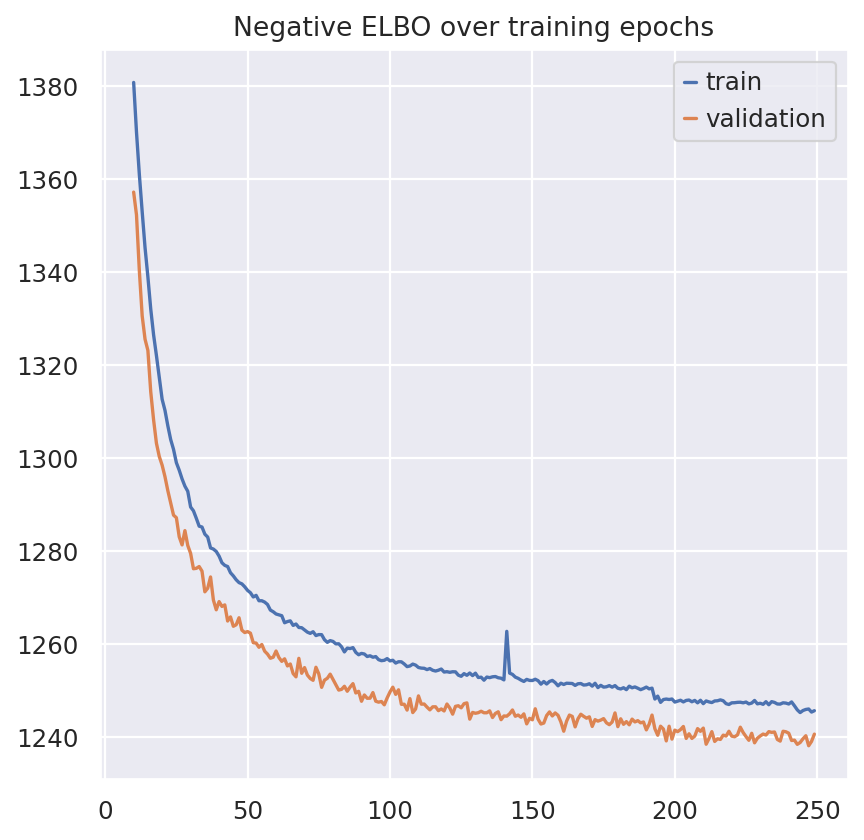

In [12]:
plt.plot(model.history["elbo_train"].iloc[10:], label="train")
plt.plot(model.history["elbo_validation"].iloc[10:], label="validation")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [13]:
TOTALVI_LATENT_KEY = "X_totalvi"

adata.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

### Train a classifier on the latent space

The representation of the reference data will not change when the model gets updated with query data. Therefore, we can train any simple classifier on the latent space. Here we use a Random Forest from scikit-learn.

By storing the classifier object in our totalVI instance (and giving it an attribute that ends with `_`), we can automatically save and load this classifier along with our model.

In [14]:
y_train = adata.obs["celltype.l2"].astype("category").cat.codes.to_numpy()
X_train = adata.obsm[TOTALVI_LATENT_KEY]
clf = RandomForestClassifier(
    random_state=1,
    class_weight="balanced_subsample",
    verbose=1,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

model.latent_space_classifer_ = clf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


### Inspect reference model

We can view the latent space using UMAP and plot the study-derived cell type labels.

Here we use the umap API instead of scanpy so that we can later use the same umap object on the query data.

In [15]:
TOTALVI_UMAP_KEY = "X_umap"

X = adata.obsm[TOTALVI_LATENT_KEY]
trans = umap.UMAP(
    n_neighbors=10,
    random_state=42,
    min_dist=0.4,
)
adata.obsm[TOTALVI_UMAP_KEY] = trans.fit_transform(X)

model.umap_op_ = trans

/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


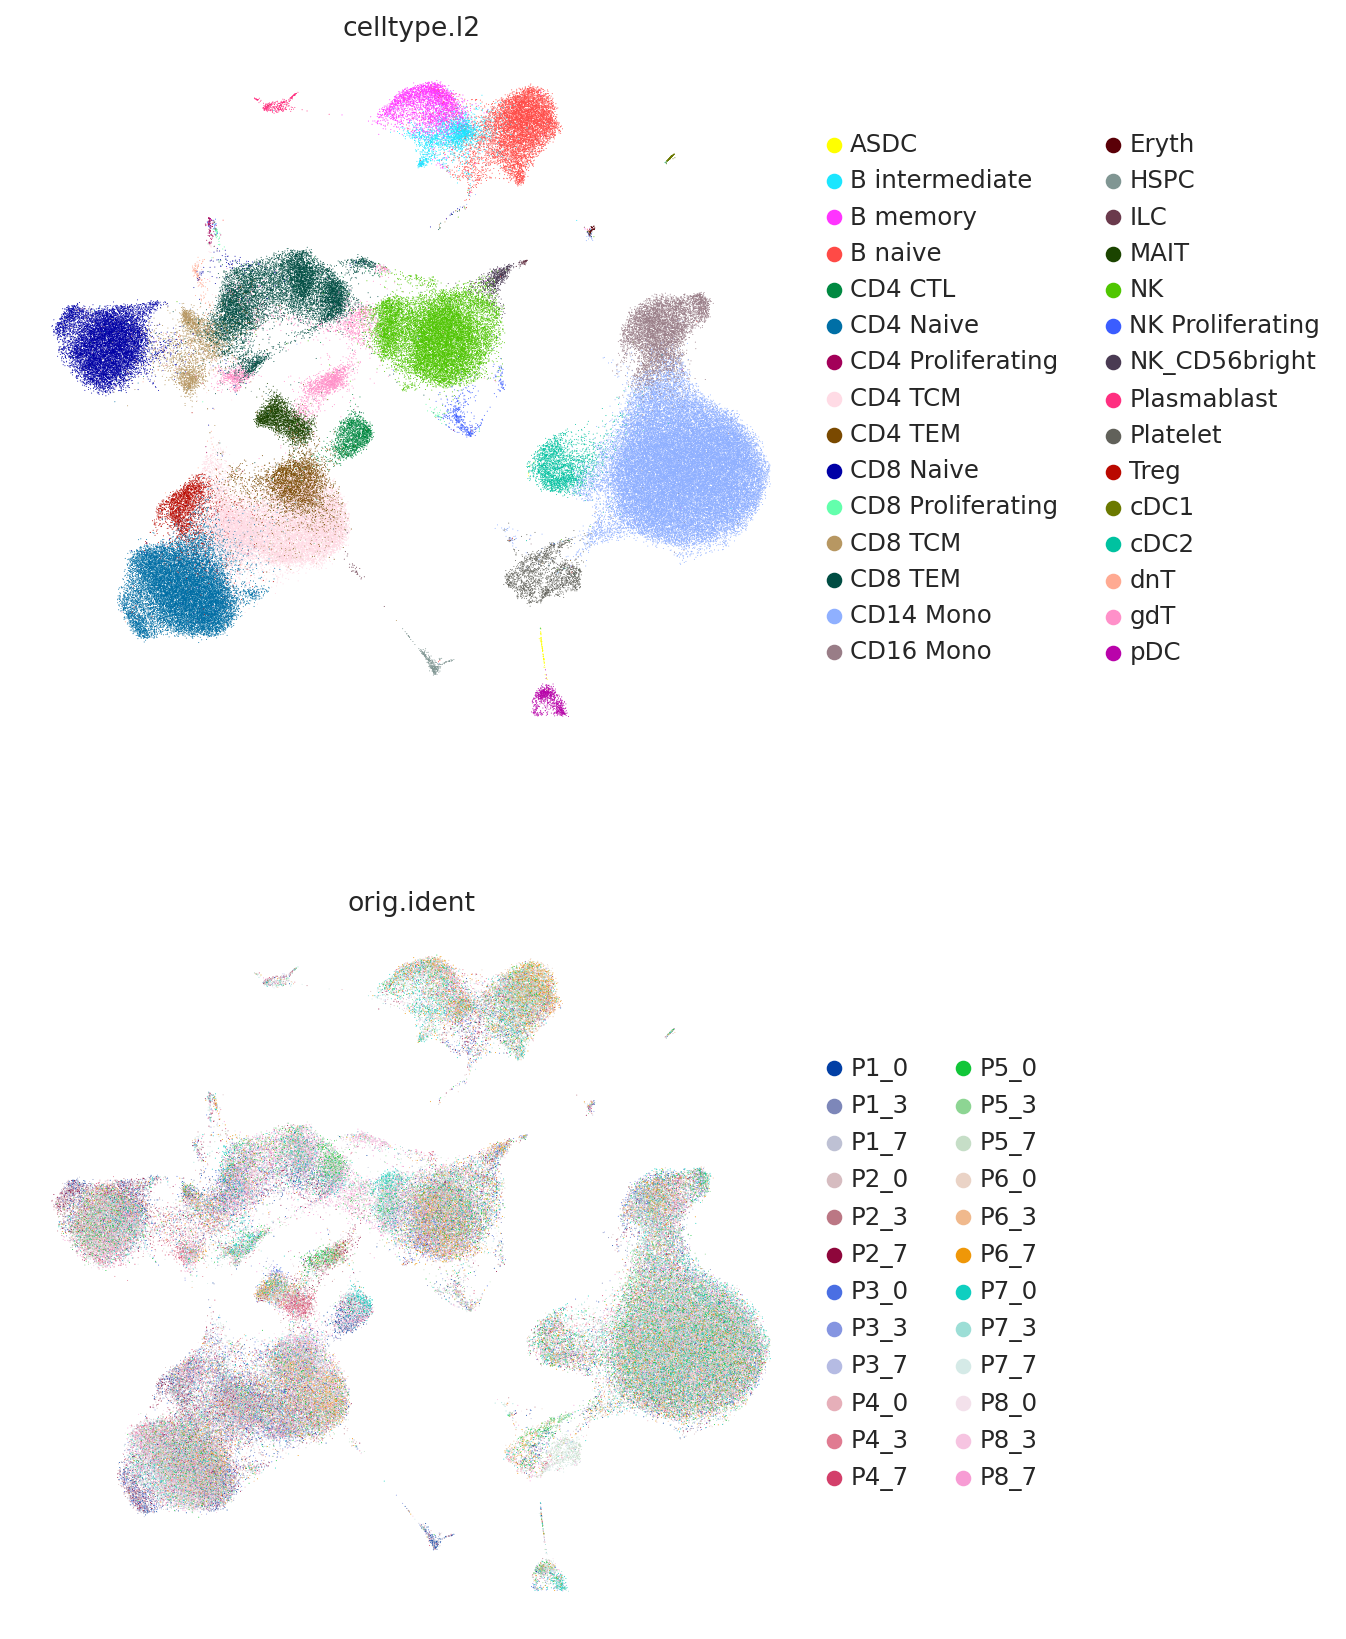

In [16]:
sc.pl.umap(
    adata,
    color=["celltype.l2", "orig.ident"],
    frameon=False,
    ncols=1,
)

## Map query data

Now we download our query data and cover the preprocessing necessary to map with our reference model.

In this case our query data are also PBMCs and come from the following study:

- Arunachalam, Prabhu S., et al. "Systems biological assessment of immunity to mild versus severe COVID-19 infection in humans." Science 369.6508 (2020): 1210-1220.

This dataset is also CITE-seq, but contains a subset of the proteins of the reference data.

In [17]:
query_path = os.path.join(save_dir.name, "covid_cite.h5ad")

query = sc.read(query_path, backup_url="https://ndownloader.figshare.com/files/27458837")

  0%|          | 0.00/289M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


### Preprocessing

First we remove any doublets from the query dataset using Scrublet. This has to be run per batch, which in this dataset is denoted with `"set"`.

In [18]:
query.obs["doublet_scores"] = 0
query.obs["predicted_doublets"] = True
for s in np.unique(query.obs["set"]):
    mask = query.obs["set"] == s
    counts_matrix = query[mask].X.copy()
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    query.obs["doublet_scores"].iloc[mask] = doublet_scores
    query.obs["predicted_doublets"].iloc[mask] = predicted_doublets

Preprocessing...


Simulating doublets...


Embedding transcriptomes using PCA...


Calculating doublet scores...


Automatically set threshold at doublet score = 0.37
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 40.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.9%
Elapsed time: 33.0 seconds


/tmp/ipykernel_158/1351898786.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_158/1351898786.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Preprocessing...


Simulating doublets...


Embedding transcriptomes using PCA...


Calculating doublet scores...


Automatically set threshold at doublet score = 0.25
Detected doublet rate = 6.2%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.0%
Elapsed time: 35.9 seconds


/tmp/ipykernel_158/1351898786.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_158/1351898786.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pan

Next we do the following:

1. Store the counts in a layer, perform standard preprocessing
1. Add blank metadata that we will later fill in with predicted labels
1. Rename the batch key to correspond to the reference data
1. Add proteins with all 0 counts for the missing proteins in this query dataset

In [19]:
query.layers["counts"] = query.X.copy()
sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)
query.raw = query
# subset to reference vars
query = query[:, adata.var_names].copy()

query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
query.obs["celltype.l2"] = "Unknown"
query.obs["orig.ident"] = query.obs["set"]
query.obsm["X_umap"] = query.obs[["UMAP1", "UMAP2"]].values

# reorganize query proteins, missing proteins become all 0
for p in adata.obsm["protein_counts"].columns:
    if p not in query.obsm["protein_counts"].columns:
        query.obsm["protein_counts"][p] = 0.0
# ensure columns are in same order
query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[
    :, adata.obsm["protein_counts"].columns
]

/tmp/ipykernel_158/3669508931.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_158/3669508931.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_158/3669508931.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

For later visualization, we add some metadata to denote whether the dataset is reference of query

In [20]:
adata.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

### Query model training

In [21]:
query_model = TOTALVI.load_query_data(query, model)
query_model.train(
    max_epochs=150,
    plan_kwargs={"weight_decay": 0.0, "scale_adversarial_loss": 0.0},
)

INFO     Found batches with missing protein expression                                                             


INFO     Computing empirical prior initialization for protein background.                                          


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/env/lib/python3.11/site-packages/scvi/model/base/_utils.py:126: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_pro

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/150:   1%|          | 1/150 [00:03<07:55,  3.19s/it]

Epoch 1/150:   1%|          | 1/150 [00:03<07:55,  3.19s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.26e+3]

Epoch 2/150:   1%|          | 1/150 [00:03<07:55,  3.19s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.26e+3]

Epoch 2/150:   1%|▏         | 2/150 [00:06<07:58,  3.24s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.26e+3]

Epoch 2/150:   1%|▏         | 2/150 [00:06<07:58,  3.24s/it, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.15e+3]

Epoch 3/150:   1%|▏         | 2/150 [00:06<07:58,  3.24s/it, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.15e+3]

Epoch 3/150:   2%|▏         | 3/150 [00:09<07:55,  3.23s/it, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.15e+3]

Epoch 3/150:   2%|▏         | 3/150 [00:09<07:55,  3.23s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3] 

Epoch 4/150:   2%|▏         | 3/150 [00:09<07:55,  3.23s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3]

Epoch 4/150:   3%|▎         | 4/150 [00:12<07:52,  3.24s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.12e+3]

Epoch 4/150:   3%|▎         | 4/150 [00:12<07:52,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.1e+3]

Epoch 5/150:   3%|▎         | 4/150 [00:12<07:52,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.1e+3]

Epoch 5/150:   3%|▎         | 5/150 [00:16<07:44,  3.21s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.1e+3]

Epoch 5/150:   3%|▎         | 5/150 [00:16<07:44,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.09e+3]

Epoch 6/150:   3%|▎         | 5/150 [00:16<07:44,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.09e+3]

Epoch 6/150:   4%|▍         | 6/150 [00:19<07:39,  3.19s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.09e+3]

Epoch 6/150:   4%|▍         | 6/150 [00:19<07:39,  3.19s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.08e+3] 

Epoch 7/150:   4%|▍         | 6/150 [00:19<07:39,  3.19s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.08e+3]

Epoch 7/150:   5%|▍         | 7/150 [00:22<07:34,  3.18s/it, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.08e+3]

Epoch 7/150:   5%|▍         | 7/150 [00:22<07:34,  3.18s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 8/150:   5%|▍         | 7/150 [00:22<07:34,  3.18s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 8/150:   5%|▌         | 8/150 [00:25<07:30,  3.17s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 8/150:   5%|▌         | 8/150 [00:25<07:30,  3.17s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 9/150:   5%|▌         | 8/150 [00:25<07:30,  3.17s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 9/150:   6%|▌         | 9/150 [00:28<07:37,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 9/150:   6%|▌         | 9/150 [00:28<07:37,  3.24s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 10/150:   6%|▌         | 9/150 [00:28<07:37,  3.24s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 10/150:   7%|▋         | 10/150 [00:32<07:32,  3.23s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 10/150:   7%|▋         | 10/150 [00:32<07:32,  3.23s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 11/150:   7%|▋         | 10/150 [00:32<07:32,  3.23s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 11/150:   7%|▋         | 11/150 [00:35<07:27,  3.22s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 11/150:   7%|▋         | 11/150 [00:35<07:27,  3.22s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 12/150:   7%|▋         | 11/150 [00:35<07:27,  3.22s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 12/150:   8%|▊         | 12/150 [00:38<07:23,  3.22s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 12/150:   8%|▊         | 12/150 [00:38<07:23,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3] 

Epoch 13/150:   8%|▊         | 12/150 [00:38<07:23,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 13/150:   9%|▊         | 13/150 [00:41<07:19,  3.20s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 13/150:   9%|▊         | 13/150 [00:41<07:19,  3.20s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 14/150:   9%|▊         | 13/150 [00:41<07:19,  3.20s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 14/150:   9%|▉         | 14/150 [00:44<07:14,  3.20s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 14/150:   9%|▉         | 14/150 [00:44<07:14,  3.20s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 15/150:   9%|▉         | 14/150 [00:44<07:14,  3.20s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 15/150:  10%|█         | 15/150 [00:48<07:10,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 15/150:  10%|█         | 15/150 [00:48<07:10,  3.19s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 16/150:  10%|█         | 15/150 [00:48<07:10,  3.19s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 16/150:  11%|█         | 16/150 [00:51<07:08,  3.19s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 16/150:  11%|█         | 16/150 [00:51<07:08,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 17/150:  11%|█         | 16/150 [00:51<07:08,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 17/150:  11%|█▏        | 17/150 [00:54<07:05,  3.20s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 17/150:  11%|█▏        | 17/150 [00:54<07:05,  3.20s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3] 

Epoch 18/150:  11%|█▏        | 17/150 [00:54<07:05,  3.20s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 18/150:  12%|█▏        | 18/150 [00:57<07:01,  3.19s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 18/150:  12%|█▏        | 18/150 [00:57<07:01,  3.19s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.06e+3]

Epoch 19/150:  12%|█▏        | 18/150 [00:57<07:01,  3.19s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.06e+3]

Epoch 19/150:  13%|█▎        | 19/150 [01:00<06:57,  3.19s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.06e+3]

Epoch 19/150:  13%|█▎        | 19/150 [01:00<06:57,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 20/150:  13%|█▎        | 19/150 [01:00<06:57,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 20/150:  13%|█▎        | 20/150 [01:04<06:54,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 20/150:  13%|█▎        | 20/150 [01:04<06:54,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 21/150:  13%|█▎        | 20/150 [01:04<06:54,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 21/150:  14%|█▍        | 21/150 [01:07<06:50,  3.18s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 21/150:  14%|█▍        | 21/150 [01:07<06:50,  3.18s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 22/150:  14%|█▍        | 21/150 [01:07<06:50,  3.18s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 22/150:  15%|█▍        | 22/150 [01:10<06:52,  3.23s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 22/150:  15%|█▍        | 22/150 [01:10<06:52,  3.23s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 23/150:  15%|█▍        | 22/150 [01:10<06:52,  3.23s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 23/150:  15%|█▌        | 23/150 [01:13<06:47,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 23/150:  15%|█▌        | 23/150 [01:13<06:47,  3.21s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 24/150:  15%|█▌        | 23/150 [01:13<06:47,  3.21s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 24/150:  16%|█▌        | 24/150 [01:16<06:42,  3.19s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 24/150:  16%|█▌        | 24/150 [01:16<06:42,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 25/150:  16%|█▌        | 24/150 [01:16<06:42,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 25/150:  17%|█▋        | 25/150 [01:20<06:38,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 25/150:  17%|█▋        | 25/150 [01:20<06:38,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 26/150:  17%|█▋        | 25/150 [01:20<06:38,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 26/150:  17%|█▋        | 26/150 [01:23<06:34,  3.18s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 26/150:  17%|█▋        | 26/150 [01:23<06:34,  3.18s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 27/150:  17%|█▋        | 26/150 [01:23<06:34,  3.18s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 27/150:  18%|█▊        | 27/150 [01:26<06:31,  3.18s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 27/150:  18%|█▊        | 27/150 [01:26<06:31,  3.18s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 28/150:  18%|█▊        | 27/150 [01:26<06:31,  3.18s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 28/150:  19%|█▊        | 28/150 [01:29<06:29,  3.19s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 28/150:  19%|█▊        | 28/150 [01:29<06:29,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 29/150:  19%|█▊        | 28/150 [01:29<06:29,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 29/150:  19%|█▉        | 29/150 [01:32<06:26,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 29/150:  19%|█▉        | 29/150 [01:32<06:26,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 30/150:  19%|█▉        | 29/150 [01:32<06:26,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 30/150:  20%|██        | 30/150 [01:36<06:24,  3.21s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 30/150:  20%|██        | 30/150 [01:36<06:24,  3.21s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3] 

Epoch 31/150:  20%|██        | 30/150 [01:36<06:24,  3.21s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 31/150:  21%|██        | 31/150 [01:39<06:22,  3.21s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 31/150:  21%|██        | 31/150 [01:39<06:22,  3.21s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 32/150:  21%|██        | 31/150 [01:39<06:22,  3.21s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 32/150:  21%|██▏       | 32/150 [01:42<06:20,  3.22s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 32/150:  21%|██▏       | 32/150 [01:42<06:20,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 33/150:  21%|██▏       | 32/150 [01:42<06:20,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 33/150:  22%|██▏       | 33/150 [01:45<06:16,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 33/150:  22%|██▏       | 33/150 [01:45<06:16,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 34/150:  22%|██▏       | 33/150 [01:45<06:16,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 34/150:  23%|██▎       | 34/150 [01:48<06:14,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 34/150:  23%|██▎       | 34/150 [01:48<06:14,  3.22s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]   

Epoch 35/150:  23%|██▎       | 34/150 [01:48<06:14,  3.22s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]

Epoch 35/150:  23%|██▎       | 35/150 [01:52<06:17,  3.28s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]

Epoch 35/150:  23%|██▎       | 35/150 [01:52<06:17,  3.28s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 36/150:  23%|██▎       | 35/150 [01:52<06:17,  3.28s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 36/150:  24%|██▍       | 36/150 [01:55<06:12,  3.27s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 36/150:  24%|██▍       | 36/150 [01:55<06:12,  3.27s/it, v_num=1, train_loss_step=999, train_loss_epoch=1.06e+3]    

Epoch 37/150:  24%|██▍       | 36/150 [01:55<06:12,  3.27s/it, v_num=1, train_loss_step=999, train_loss_epoch=1.06e+3]

Epoch 37/150:  25%|██▍       | 37/150 [01:58<06:08,  3.26s/it, v_num=1, train_loss_step=999, train_loss_epoch=1.06e+3]

Epoch 37/150:  25%|██▍       | 37/150 [01:58<06:08,  3.26s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 38/150:  25%|██▍       | 37/150 [01:58<06:08,  3.26s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 38/150:  25%|██▌       | 38/150 [02:02<06:04,  3.25s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 38/150:  25%|██▌       | 38/150 [02:02<06:04,  3.25s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 39/150:  25%|██▌       | 38/150 [02:02<06:04,  3.25s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 39/150:  26%|██▌       | 39/150 [02:05<06:00,  3.25s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 39/150:  26%|██▌       | 39/150 [02:05<06:00,  3.25s/it, v_num=1, train_loss_step=989, train_loss_epoch=1.06e+3]    

Epoch 40/150:  26%|██▌       | 39/150 [02:05<06:00,  3.25s/it, v_num=1, train_loss_step=989, train_loss_epoch=1.06e+3]

Epoch 40/150:  27%|██▋       | 40/150 [02:08<05:56,  3.24s/it, v_num=1, train_loss_step=989, train_loss_epoch=1.06e+3]

Epoch 40/150:  27%|██▋       | 40/150 [02:08<05:56,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 41/150:  27%|██▋       | 40/150 [02:08<05:56,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 41/150:  27%|██▋       | 41/150 [02:11<05:53,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 41/150:  27%|██▋       | 41/150 [02:11<05:53,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 42/150:  27%|██▋       | 41/150 [02:11<05:53,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 42/150:  28%|██▊       | 42/150 [02:15<05:50,  3.25s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 42/150:  28%|██▊       | 42/150 [02:15<05:50,  3.25s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 43/150:  28%|██▊       | 42/150 [02:15<05:50,  3.25s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 43/150:  29%|██▊       | 43/150 [02:18<05:46,  3.24s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 43/150:  29%|██▊       | 43/150 [02:18<05:46,  3.24s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 44/150:  29%|██▊       | 43/150 [02:18<05:46,  3.24s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 44/150:  29%|██▉       | 44/150 [02:21<05:43,  3.24s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 44/150:  29%|██▉       | 44/150 [02:21<05:43,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 45/150:  29%|██▉       | 44/150 [02:21<05:43,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 45/150:  30%|███       | 45/150 [02:24<05:39,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 45/150:  30%|███       | 45/150 [02:24<05:39,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 46/150:  30%|███       | 45/150 [02:24<05:39,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 46/150:  31%|███       | 46/150 [02:27<05:35,  3.23s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 46/150:  31%|███       | 46/150 [02:27<05:35,  3.23s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 47/150:  31%|███       | 46/150 [02:27<05:35,  3.23s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 47/150:  31%|███▏      | 47/150 [02:31<05:32,  3.23s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 47/150:  31%|███▏      | 47/150 [02:31<05:32,  3.23s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 48/150:  31%|███▏      | 47/150 [02:31<05:32,  3.23s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 48/150:  32%|███▏      | 48/150 [02:34<05:33,  3.27s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 48/150:  32%|███▏      | 48/150 [02:34<05:33,  3.27s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 49/150:  32%|███▏      | 48/150 [02:34<05:33,  3.27s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 49/150:  33%|███▎      | 49/150 [02:37<05:28,  3.26s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 49/150:  33%|███▎      | 49/150 [02:37<05:28,  3.26s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 50/150:  33%|███▎      | 49/150 [02:37<05:28,  3.26s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 50/150:  33%|███▎      | 50/150 [02:41<05:25,  3.25s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 50/150:  33%|███▎      | 50/150 [02:41<05:25,  3.25s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.06e+3]

Epoch 51/150:  33%|███▎      | 50/150 [02:41<05:25,  3.25s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.06e+3]

Epoch 51/150:  34%|███▍      | 51/150 [02:44<05:21,  3.25s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.06e+3]

Epoch 51/150:  34%|███▍      | 51/150 [02:44<05:21,  3.25s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 52/150:  34%|███▍      | 51/150 [02:44<05:21,  3.25s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 52/150:  35%|███▍      | 52/150 [02:47<05:18,  3.25s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 52/150:  35%|███▍      | 52/150 [02:47<05:18,  3.25s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 53/150:  35%|███▍      | 52/150 [02:47<05:18,  3.25s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 53/150:  35%|███▌      | 53/150 [02:50<05:17,  3.27s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 53/150:  35%|███▌      | 53/150 [02:50<05:17,  3.27s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 54/150:  35%|███▌      | 53/150 [02:50<05:17,  3.27s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 54/150:  36%|███▌      | 54/150 [02:54<05:15,  3.29s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 54/150:  36%|███▌      | 54/150 [02:54<05:15,  3.29s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 55/150:  36%|███▌      | 54/150 [02:54<05:15,  3.29s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 55/150:  37%|███▋      | 55/150 [02:57<05:09,  3.25s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 55/150:  37%|███▋      | 55/150 [02:57<05:09,  3.25s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 56/150:  37%|███▋      | 55/150 [02:57<05:09,  3.25s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 56/150:  37%|███▋      | 56/150 [03:00<05:03,  3.23s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 56/150:  37%|███▋      | 56/150 [03:00<05:03,  3.23s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.06e+3]

Epoch 57/150:  37%|███▋      | 56/150 [03:00<05:03,  3.23s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.06e+3]

Epoch 57/150:  38%|███▊      | 57/150 [03:03<04:58,  3.21s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.06e+3]

Epoch 57/150:  38%|███▊      | 57/150 [03:03<04:58,  3.21s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.06e+3]

Epoch 58/150:  38%|███▊      | 57/150 [03:03<04:58,  3.21s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.06e+3]

Epoch 58/150:  39%|███▊      | 58/150 [03:06<04:54,  3.20s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.06e+3]

Epoch 58/150:  39%|███▊      | 58/150 [03:06<04:54,  3.20s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 59/150:  39%|███▊      | 58/150 [03:06<04:54,  3.20s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 59/150:  39%|███▉      | 59/150 [03:10<04:50,  3.19s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 59/150:  39%|███▉      | 59/150 [03:10<04:50,  3.19s/it, v_num=1, train_loss_step=971, train_loss_epoch=1.06e+3]    

Epoch 60/150:  39%|███▉      | 59/150 [03:10<04:50,  3.19s/it, v_num=1, train_loss_step=971, train_loss_epoch=1.06e+3]

Epoch 60/150:  40%|████      | 60/150 [03:13<04:51,  3.24s/it, v_num=1, train_loss_step=971, train_loss_epoch=1.06e+3]

Epoch 60/150:  40%|████      | 60/150 [03:13<04:51,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 61/150:  40%|████      | 60/150 [03:13<04:51,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 61/150:  41%|████      | 61/150 [03:16<04:47,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 61/150:  41%|████      | 61/150 [03:16<04:47,  3.24s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3] 

Epoch 62/150:  41%|████      | 61/150 [03:16<04:47,  3.24s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 62/150:  41%|████▏     | 62/150 [03:19<04:42,  3.21s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 62/150:  41%|████▏     | 62/150 [03:19<04:42,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 63/150:  41%|████▏     | 62/150 [03:19<04:42,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 63/150:  42%|████▏     | 63/150 [03:22<04:37,  3.19s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 63/150:  42%|████▏     | 63/150 [03:22<04:37,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 64/150:  42%|████▏     | 63/150 [03:22<04:37,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 64/150:  43%|████▎     | 64/150 [03:26<04:33,  3.18s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 64/150:  43%|████▎     | 64/150 [03:26<04:33,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 65/150:  43%|████▎     | 64/150 [03:26<04:33,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 65/150:  43%|████▎     | 65/150 [03:29<04:29,  3.17s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 65/150:  43%|████▎     | 65/150 [03:29<04:29,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 66/150:  43%|████▎     | 65/150 [03:29<04:29,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 66/150:  44%|████▍     | 66/150 [03:32<04:25,  3.16s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 66/150:  44%|████▍     | 66/150 [03:32<04:25,  3.16s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]   

Epoch 67/150:  44%|████▍     | 66/150 [03:32<04:25,  3.16s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]

Epoch 67/150:  45%|████▍     | 67/150 [03:35<04:22,  3.16s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]

Epoch 67/150:  45%|████▍     | 67/150 [03:35<04:22,  3.16s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 68/150:  45%|████▍     | 67/150 [03:35<04:22,  3.16s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 68/150:  45%|████▌     | 68/150 [03:38<04:18,  3.16s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 68/150:  45%|████▌     | 68/150 [03:38<04:18,  3.16s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 69/150:  45%|████▌     | 68/150 [03:38<04:18,  3.16s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 69/150:  46%|████▌     | 69/150 [03:41<04:15,  3.15s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 69/150:  46%|████▌     | 69/150 [03:41<04:15,  3.15s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 70/150:  46%|████▌     | 69/150 [03:41<04:15,  3.15s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 70/150:  47%|████▋     | 70/150 [03:44<04:12,  3.15s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 70/150:  47%|████▋     | 70/150 [03:44<04:12,  3.15s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 71/150:  47%|████▋     | 70/150 [03:44<04:12,  3.15s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 71/150:  47%|████▋     | 71/150 [03:48<04:08,  3.15s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 71/150:  47%|████▋     | 71/150 [03:48<04:08,  3.15s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 72/150:  47%|████▋     | 71/150 [03:48<04:08,  3.15s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 72/150:  48%|████▊     | 72/150 [03:51<04:06,  3.16s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 72/150:  48%|████▊     | 72/150 [03:51<04:06,  3.16s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 73/150:  48%|████▊     | 72/150 [03:51<04:06,  3.16s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 73/150:  49%|████▊     | 73/150 [03:54<04:08,  3.23s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 73/150:  49%|████▊     | 73/150 [03:54<04:08,  3.23s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 74/150:  49%|████▊     | 73/150 [03:54<04:08,  3.23s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 74/150:  49%|████▉     | 74/150 [03:57<04:04,  3.22s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 74/150:  49%|████▉     | 74/150 [03:57<04:04,  3.22s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 75/150:  49%|████▉     | 74/150 [03:57<04:04,  3.22s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 75/150:  50%|█████     | 75/150 [04:01<04:01,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3]

Epoch 75/150:  50%|█████     | 75/150 [04:01<04:01,  3.21s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 76/150:  50%|█████     | 75/150 [04:01<04:01,  3.21s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 76/150:  51%|█████     | 76/150 [04:04<03:57,  3.21s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 76/150:  51%|█████     | 76/150 [04:04<03:57,  3.21s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 77/150:  51%|█████     | 76/150 [04:04<03:57,  3.21s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 77/150:  51%|█████▏    | 77/150 [04:07<03:54,  3.21s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 77/150:  51%|█████▏    | 77/150 [04:07<03:54,  3.21s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 78/150:  51%|█████▏    | 77/150 [04:07<03:54,  3.21s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 78/150:  52%|█████▏    | 78/150 [04:10<03:50,  3.21s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 78/150:  52%|█████▏    | 78/150 [04:10<03:50,  3.21s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 79/150:  52%|█████▏    | 78/150 [04:10<03:50,  3.21s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 79/150:  53%|█████▎    | 79/150 [04:13<03:47,  3.21s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.06e+3]

Epoch 79/150:  53%|█████▎    | 79/150 [04:13<03:47,  3.21s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 80/150:  53%|█████▎    | 79/150 [04:13<03:47,  3.21s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 80/150:  53%|█████▎    | 80/150 [04:17<03:44,  3.21s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 80/150:  53%|█████▎    | 80/150 [04:17<03:44,  3.21s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 81/150:  53%|█████▎    | 80/150 [04:17<03:44,  3.21s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 81/150:  54%|█████▍    | 81/150 [04:20<03:41,  3.21s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 81/150:  54%|█████▍    | 81/150 [04:20<03:41,  3.21s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.06e+3]

Epoch 82/150:  54%|█████▍    | 81/150 [04:20<03:41,  3.21s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.06e+3]

Epoch 82/150:  55%|█████▍    | 82/150 [04:23<03:38,  3.21s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.06e+3]

Epoch 82/150:  55%|█████▍    | 82/150 [04:23<03:38,  3.21s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3] 

Epoch 83/150:  55%|█████▍    | 82/150 [04:23<03:38,  3.21s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 83/150:  55%|█████▌    | 83/150 [04:26<03:35,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 83/150:  55%|█████▌    | 83/150 [04:26<03:35,  3.22s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 84/150:  55%|█████▌    | 83/150 [04:26<03:35,  3.22s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 84/150:  56%|█████▌    | 84/150 [04:29<03:32,  3.22s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 84/150:  56%|█████▌    | 84/150 [04:29<03:32,  3.22s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 85/150:  56%|█████▌    | 84/150 [04:29<03:32,  3.22s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 85/150:  57%|█████▋    | 85/150 [04:33<03:28,  3.20s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 85/150:  57%|█████▋    | 85/150 [04:33<03:28,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 86/150:  57%|█████▋    | 85/150 [04:33<03:28,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 86/150:  57%|█████▋    | 86/150 [04:36<03:27,  3.24s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 86/150:  57%|█████▋    | 86/150 [04:36<03:27,  3.24s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 87/150:  57%|█████▋    | 86/150 [04:36<03:27,  3.24s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 87/150:  58%|█████▊    | 87/150 [04:39<03:23,  3.22s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 87/150:  58%|█████▊    | 87/150 [04:39<03:23,  3.22s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 88/150:  58%|█████▊    | 87/150 [04:39<03:23,  3.22s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 88/150:  59%|█████▊    | 88/150 [04:42<03:19,  3.22s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 88/150:  59%|█████▊    | 88/150 [04:42<03:19,  3.22s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]   

Epoch 89/150:  59%|█████▊    | 88/150 [04:42<03:19,  3.22s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]

Epoch 89/150:  59%|█████▉    | 89/150 [04:46<03:15,  3.21s/it, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.06e+3]

Epoch 89/150:  59%|█████▉    | 89/150 [04:46<03:15,  3.21s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 90/150:  59%|█████▉    | 89/150 [04:46<03:15,  3.21s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 90/150:  60%|██████    | 90/150 [04:49<03:11,  3.20s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 90/150:  60%|██████    | 90/150 [04:49<03:11,  3.20s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 91/150:  60%|██████    | 90/150 [04:49<03:11,  3.20s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 91/150:  61%|██████    | 91/150 [04:52<03:08,  3.19s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 91/150:  61%|██████    | 91/150 [04:52<03:08,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 92/150:  61%|██████    | 91/150 [04:52<03:08,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 92/150:  61%|██████▏   | 92/150 [04:55<03:04,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 92/150:  61%|██████▏   | 92/150 [04:55<03:04,  3.19s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 93/150:  61%|██████▏   | 92/150 [04:55<03:04,  3.19s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 93/150:  62%|██████▏   | 93/150 [04:58<03:02,  3.19s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.06e+3]

Epoch 93/150:  62%|██████▏   | 93/150 [04:58<03:02,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 94/150:  62%|██████▏   | 93/150 [04:58<03:02,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 94/150:  63%|██████▎   | 94/150 [05:01<02:59,  3.20s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.06e+3]

Epoch 94/150:  63%|██████▎   | 94/150 [05:01<02:59,  3.20s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 95/150:  63%|██████▎   | 94/150 [05:01<02:59,  3.20s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 95/150:  63%|██████▎   | 95/150 [05:05<02:55,  3.20s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.06e+3]

Epoch 95/150:  63%|██████▎   | 95/150 [05:05<02:55,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 96/150:  63%|██████▎   | 95/150 [05:05<02:55,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 96/150:  64%|██████▍   | 96/150 [05:08<02:53,  3.21s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 96/150:  64%|██████▍   | 96/150 [05:08<02:53,  3.21s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 97/150:  64%|██████▍   | 96/150 [05:08<02:53,  3.21s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 97/150:  65%|██████▍   | 97/150 [05:11<02:49,  3.21s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 97/150:  65%|██████▍   | 97/150 [05:11<02:49,  3.21s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 98/150:  65%|██████▍   | 97/150 [05:11<02:49,  3.21s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 98/150:  65%|██████▌   | 98/150 [05:14<02:46,  3.20s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 98/150:  65%|██████▌   | 98/150 [05:14<02:46,  3.20s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 99/150:  65%|██████▌   | 98/150 [05:14<02:46,  3.20s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 99/150:  66%|██████▌   | 99/150 [05:18<02:45,  3.25s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 99/150:  66%|██████▌   | 99/150 [05:18<02:45,  3.25s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 100/150:  66%|██████▌   | 99/150 [05:18<02:45,  3.25s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 100/150:  67%|██████▋   | 100/150 [05:21<02:41,  3.24s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 100/150:  67%|██████▋   | 100/150 [05:21<02:41,  3.24s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]

Epoch 101/150:  67%|██████▋   | 100/150 [05:21<02:41,  3.24s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]

Epoch 101/150:  67%|██████▋   | 101/150 [05:24<02:37,  3.22s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]

Epoch 101/150:  67%|██████▋   | 101/150 [05:24<02:37,  3.22s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 102/150:  67%|██████▋   | 101/150 [05:24<02:37,  3.22s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 102/150:  68%|██████▊   | 102/150 [05:27<02:33,  3.21s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 102/150:  68%|██████▊   | 102/150 [05:27<02:33,  3.21s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 103/150:  68%|██████▊   | 102/150 [05:27<02:33,  3.21s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 103/150:  69%|██████▊   | 103/150 [05:30<02:30,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 103/150:  69%|██████▊   | 103/150 [05:30<02:30,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 104/150:  69%|██████▊   | 103/150 [05:30<02:30,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 104/150:  69%|██████▉   | 104/150 [05:34<02:26,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 104/150:  69%|██████▉   | 104/150 [05:34<02:26,  3.19s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3] 

Epoch 105/150:  69%|██████▉   | 104/150 [05:34<02:26,  3.19s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 105/150:  70%|███████   | 105/150 [05:37<02:23,  3.18s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 105/150:  70%|███████   | 105/150 [05:37<02:23,  3.18s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 106/150:  70%|███████   | 105/150 [05:37<02:23,  3.18s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 106/150:  71%|███████   | 106/150 [05:40<02:20,  3.19s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 106/150:  71%|███████   | 106/150 [05:40<02:20,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 107/150:  71%|███████   | 106/150 [05:40<02:20,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 107/150:  71%|███████▏  | 107/150 [05:43<02:17,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 107/150:  71%|███████▏  | 107/150 [05:43<02:17,  3.20s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 108/150:  71%|███████▏  | 107/150 [05:43<02:17,  3.20s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 108/150:  72%|███████▏  | 108/150 [05:46<02:14,  3.19s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 108/150:  72%|███████▏  | 108/150 [05:46<02:14,  3.19s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 109/150:  72%|███████▏  | 108/150 [05:46<02:14,  3.19s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 109/150:  73%|███████▎  | 109/150 [05:50<02:10,  3.18s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 109/150:  73%|███████▎  | 109/150 [05:50<02:10,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 110/150:  73%|███████▎  | 109/150 [05:50<02:10,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 110/150:  73%|███████▎  | 110/150 [05:53<02:07,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 110/150:  73%|███████▎  | 110/150 [05:53<02:07,  3.18s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 111/150:  73%|███████▎  | 110/150 [05:53<02:07,  3.18s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 111/150:  74%|███████▍  | 111/150 [05:56<02:03,  3.17s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.07e+3]

Epoch 111/150:  74%|███████▍  | 111/150 [05:56<02:03,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 112/150:  74%|███████▍  | 111/150 [05:56<02:03,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 112/150:  75%|███████▍  | 112/150 [05:59<02:02,  3.22s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 112/150:  75%|███████▍  | 112/150 [05:59<02:02,  3.22s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 113/150:  75%|███████▍  | 112/150 [05:59<02:02,  3.22s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 113/150:  75%|███████▌  | 113/150 [06:02<01:58,  3.20s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 113/150:  75%|███████▌  | 113/150 [06:02<01:58,  3.20s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 114/150:  75%|███████▌  | 113/150 [06:02<01:58,  3.20s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 114/150:  76%|███████▌  | 114/150 [06:05<01:54,  3.19s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 114/150:  76%|███████▌  | 114/150 [06:05<01:54,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 115/150:  76%|███████▌  | 114/150 [06:05<01:54,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 115/150:  77%|███████▋  | 115/150 [06:09<01:51,  3.18s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 115/150:  77%|███████▋  | 115/150 [06:09<01:51,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 116/150:  77%|███████▋  | 115/150 [06:09<01:51,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 116/150:  77%|███████▋  | 116/150 [06:12<01:48,  3.18s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 116/150:  77%|███████▋  | 116/150 [06:12<01:48,  3.18s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 117/150:  77%|███████▋  | 116/150 [06:12<01:48,  3.18s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 117/150:  78%|███████▊  | 117/150 [06:15<01:44,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 117/150:  78%|███████▊  | 117/150 [06:15<01:44,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 118/150:  78%|███████▊  | 117/150 [06:15<01:44,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 118/150:  79%|███████▊  | 118/150 [06:18<01:41,  3.17s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 118/150:  79%|███████▊  | 118/150 [06:18<01:41,  3.17s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 119/150:  79%|███████▊  | 118/150 [06:18<01:41,  3.17s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 119/150:  79%|███████▉  | 119/150 [06:21<01:38,  3.18s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 119/150:  79%|███████▉  | 119/150 [06:21<01:38,  3.18s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 120/150:  79%|███████▉  | 119/150 [06:21<01:38,  3.18s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 120/150:  80%|████████  | 120/150 [06:25<01:36,  3.20s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 120/150:  80%|████████  | 120/150 [06:25<01:36,  3.20s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 121/150:  80%|████████  | 120/150 [06:25<01:36,  3.20s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 121/150:  81%|████████  | 121/150 [06:28<01:33,  3.22s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 121/150:  81%|████████  | 121/150 [06:28<01:33,  3.22s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 122/150:  81%|████████  | 121/150 [06:28<01:33,  3.22s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 122/150:  81%|████████▏ | 122/150 [06:31<01:30,  3.22s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 122/150:  81%|████████▏ | 122/150 [06:31<01:30,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 123/150:  81%|████████▏ | 122/150 [06:31<01:30,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 123/150:  82%|████████▏ | 123/150 [06:34<01:26,  3.22s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 123/150:  82%|████████▏ | 123/150 [06:34<01:26,  3.22s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 124/150:  82%|████████▏ | 123/150 [06:34<01:26,  3.22s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 124/150:  83%|████████▎ | 124/150 [06:38<01:23,  3.22s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 124/150:  83%|████████▎ | 124/150 [06:38<01:23,  3.22s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 125/150:  83%|████████▎ | 124/150 [06:38<01:23,  3.22s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 125/150:  83%|████████▎ | 125/150 [06:41<01:21,  3.28s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 125/150:  83%|████████▎ | 125/150 [06:41<01:21,  3.28s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 126/150:  83%|████████▎ | 125/150 [06:41<01:21,  3.28s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 126/150:  84%|████████▍ | 126/150 [06:44<01:18,  3.26s/it, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 126/150:  84%|████████▍ | 126/150 [06:44<01:18,  3.26s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 127/150:  84%|████████▍ | 126/150 [06:44<01:18,  3.26s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 127/150:  85%|████████▍ | 127/150 [06:47<01:14,  3.24s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 127/150:  85%|████████▍ | 127/150 [06:47<01:14,  3.24s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 128/150:  85%|████████▍ | 127/150 [06:47<01:14,  3.24s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 128/150:  85%|████████▌ | 128/150 [06:51<01:11,  3.23s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 128/150:  85%|████████▌ | 128/150 [06:51<01:11,  3.23s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 129/150:  85%|████████▌ | 128/150 [06:51<01:11,  3.23s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 129/150:  86%|████████▌ | 129/150 [06:54<01:07,  3.22s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 129/150:  86%|████████▌ | 129/150 [06:54<01:07,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3] 

Epoch 130/150:  86%|████████▌ | 129/150 [06:54<01:07,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 130/150:  87%|████████▋ | 130/150 [06:57<01:04,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 130/150:  87%|████████▋ | 130/150 [06:57<01:04,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 131/150:  87%|████████▋ | 130/150 [06:57<01:04,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 131/150:  87%|████████▋ | 131/150 [07:00<01:01,  3.22s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.07e+3]

Epoch 131/150:  87%|████████▋ | 131/150 [07:00<01:01,  3.22s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.07e+3]

Epoch 132/150:  87%|████████▋ | 131/150 [07:00<01:01,  3.22s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.07e+3]

Epoch 132/150:  88%|████████▊ | 132/150 [07:03<00:57,  3.20s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.07e+3]

Epoch 132/150:  88%|████████▊ | 132/150 [07:03<00:57,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 133/150:  88%|████████▊ | 132/150 [07:03<00:57,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 133/150:  89%|████████▊ | 133/150 [07:07<00:54,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 133/150:  89%|████████▊ | 133/150 [07:07<00:54,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 134/150:  89%|████████▊ | 133/150 [07:07<00:54,  3.20s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 134/150:  89%|████████▉ | 134/150 [07:10<00:50,  3.19s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 134/150:  89%|████████▉ | 134/150 [07:10<00:50,  3.19s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 135/150:  89%|████████▉ | 134/150 [07:10<00:50,  3.19s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 135/150:  90%|█████████ | 135/150 [07:13<00:47,  3.19s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.07e+3]

Epoch 135/150:  90%|█████████ | 135/150 [07:13<00:47,  3.19s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 136/150:  90%|█████████ | 135/150 [07:13<00:47,  3.19s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 136/150:  91%|█████████ | 136/150 [07:16<00:44,  3.19s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 136/150:  91%|█████████ | 136/150 [07:16<00:44,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 137/150:  91%|█████████ | 136/150 [07:16<00:44,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 137/150:  91%|█████████▏| 137/150 [07:19<00:41,  3.19s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 137/150:  91%|█████████▏| 137/150 [07:19<00:41,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 138/150:  91%|█████████▏| 137/150 [07:19<00:41,  3.19s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 138/150:  92%|█████████▏| 138/150 [07:23<00:38,  3.24s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.07e+3]

Epoch 138/150:  92%|█████████▏| 138/150 [07:23<00:38,  3.24s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 139/150:  92%|█████████▏| 138/150 [07:23<00:38,  3.24s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 139/150:  93%|█████████▎| 139/150 [07:26<00:35,  3.24s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 139/150:  93%|█████████▎| 139/150 [07:26<00:35,  3.24s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 140/150:  93%|█████████▎| 139/150 [07:26<00:35,  3.24s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 140/150:  93%|█████████▎| 140/150 [07:29<00:32,  3.21s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 140/150:  93%|█████████▎| 140/150 [07:29<00:32,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 141/150:  93%|█████████▎| 140/150 [07:29<00:32,  3.21s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 141/150:  94%|█████████▍| 141/150 [07:32<00:28,  3.19s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 141/150:  94%|█████████▍| 141/150 [07:32<00:28,  3.19s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 142/150:  94%|█████████▍| 141/150 [07:32<00:28,  3.19s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 142/150:  95%|█████████▍| 142/150 [07:35<00:25,  3.18s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 142/150:  95%|█████████▍| 142/150 [07:35<00:25,  3.18s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 143/150:  95%|█████████▍| 142/150 [07:35<00:25,  3.18s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 143/150:  95%|█████████▌| 143/150 [07:38<00:22,  3.17s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 143/150:  95%|█████████▌| 143/150 [07:38<00:22,  3.17s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 144/150:  95%|█████████▌| 143/150 [07:38<00:22,  3.17s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 144/150:  96%|█████████▌| 144/150 [07:42<00:18,  3.17s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.07e+3]

Epoch 144/150:  96%|█████████▌| 144/150 [07:42<00:18,  3.17s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 145/150:  96%|█████████▌| 144/150 [07:42<00:18,  3.17s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 145/150:  97%|█████████▋| 145/150 [07:45<00:16,  3.22s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.07e+3]

Epoch 145/150:  97%|█████████▋| 145/150 [07:45<00:16,  3.22s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]

Epoch 146/150:  97%|█████████▋| 145/150 [07:45<00:16,  3.22s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]

Epoch 146/150:  97%|█████████▋| 146/150 [07:48<00:12,  3.25s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.07e+3]

Epoch 146/150:  97%|█████████▋| 146/150 [07:48<00:12,  3.25s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 147/150:  97%|█████████▋| 146/150 [07:48<00:12,  3.25s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 147/150:  98%|█████████▊| 147/150 [07:52<00:09,  3.25s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 147/150:  98%|█████████▊| 147/150 [07:52<00:09,  3.25s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 148/150:  98%|█████████▊| 147/150 [07:52<00:09,  3.25s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 148/150:  99%|█████████▊| 148/150 [07:55<00:06,  3.27s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.07e+3]

Epoch 148/150:  99%|█████████▊| 148/150 [07:55<00:06,  3.27s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 149/150:  99%|█████████▊| 148/150 [07:55<00:06,  3.27s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 149/150:  99%|█████████▉| 149/150 [07:58<00:03,  3.27s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 149/150:  99%|█████████▉| 149/150 [07:58<00:03,  3.27s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 150/150:  99%|█████████▉| 149/150 [07:58<00:03,  3.27s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 150/150: 100%|██████████| 150/150 [08:01<00:00,  3.25s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.07e+3]

Epoch 150/150: 100%|██████████| 150/150 [08:01<00:00,  3.25s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [08:01<00:00,  3.21s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

And now we retrieve the latent representation for the query data

In [22]:
TOTALVI_QUERY_LATENT_KEY = "X_totalvi_scarches"

query.obsm[TOTALVI_QUERY_LATENT_KEY] = query_model.get_latent_representation(query)

### Query cell type prediction

We can use the random forest that we previously trained using the latent representation of the query data in the updated model!

In [23]:
# predict cell types of query
predictions = query_model.latent_space_classifer_.predict(query.obsm[TOTALVI_QUERY_LATENT_KEY])
categories = adata.obs["celltype.l2"].astype("category").cat.categories
cat_preds = [categories[i] for i in predictions]
query.obs["celltype.l2"] = cat_preds
query.obs["predicted_l2_scarches"] = cat_preds

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


### Evaluate label transfer

Now we plot the predicted labels and the labels from the query study (here denoted as `"final_clust_review"`) on the UMAP coordinated used in the query study. We can see that we have an overall strong concordance, but also some important differences. For example, the study found a population of monocytes with interferon signaling, but as the reference contains no such cell type, it can only predict them to be CD14 monocytes.

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

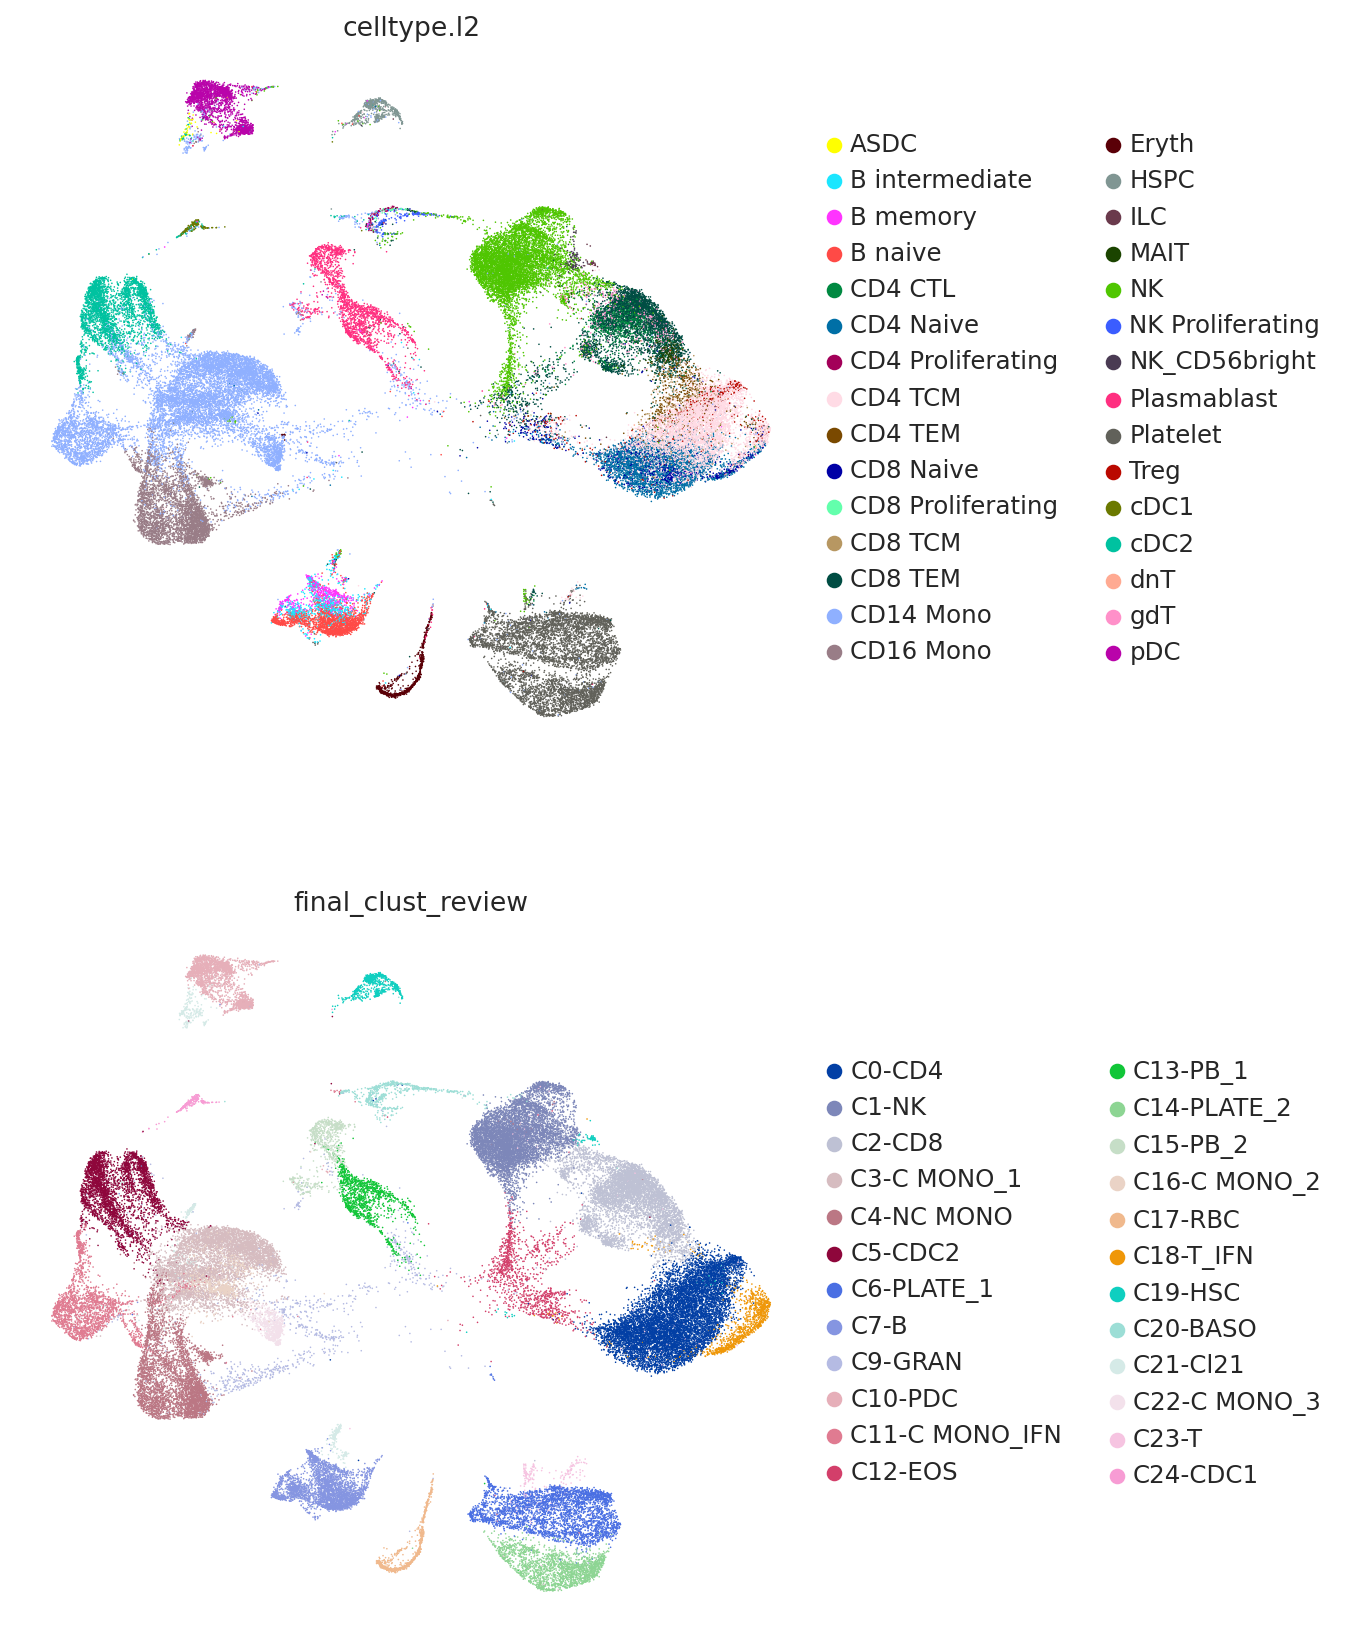

In [24]:
sc.pl.umap(
    query,
    color=["celltype.l2", "final_clust_review"],
    frameon=False,
    ncols=1,
)

### Use reference UMAP

We can also use the same UMAP operator from the reference step to visualize our query data.

In [25]:
TOTALVI_UMAP_PROJECT_KEY = "X_umap_project"

query.obsm[TOTALVI_UMAP_PROJECT_KEY] = query_model.umap_op_.transform(
    query.obsm[TOTALVI_QUERY_LATENT_KEY]
)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

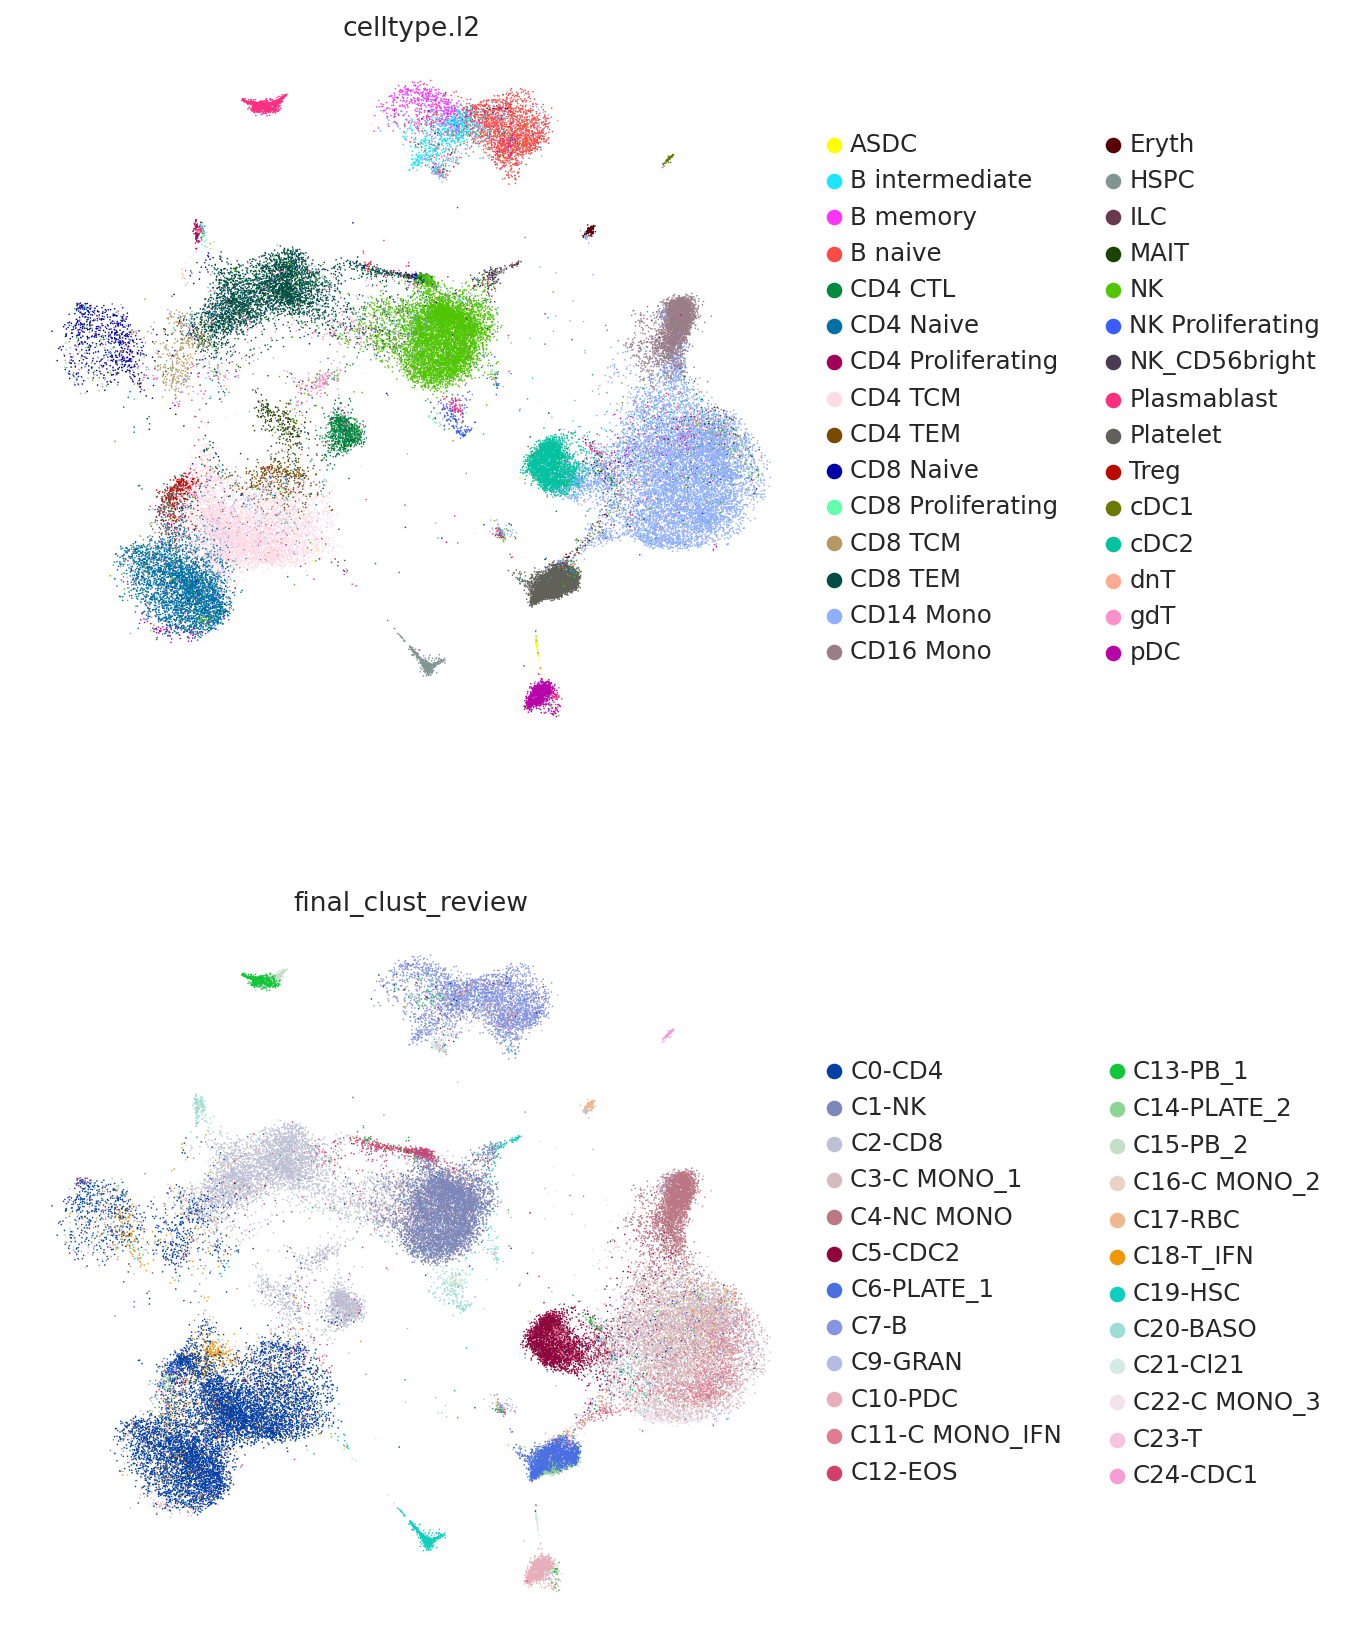

In [26]:
sc.pl.embedding(
    query,
    TOTALVI_UMAP_PROJECT_KEY,
    color=["celltype.l2", "final_clust_review"],
    frameon=False,
    ncols=1,
)

And finally we can combine the umaps together and visualize jointly.

In [27]:
umap_adata = sc.AnnData(
    np.concatenate(
        [
            query.obsm["X_umap_project"],
            adata.obsm["X_umap"],
        ],
        axis=0,
    )
)
umap_adata.obs["celltype"] = np.concatenate(
    [query.obs["celltype.l2"].values, adata.obs["celltype.l2"].values]
)
umap_adata.obs["dataset"] = np.concatenate(
    [query.shape[0] * ["query"], adata.shape[0] * ["reference"]]
)
umap_adata.obsm["X_umap"] = umap_adata.X

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


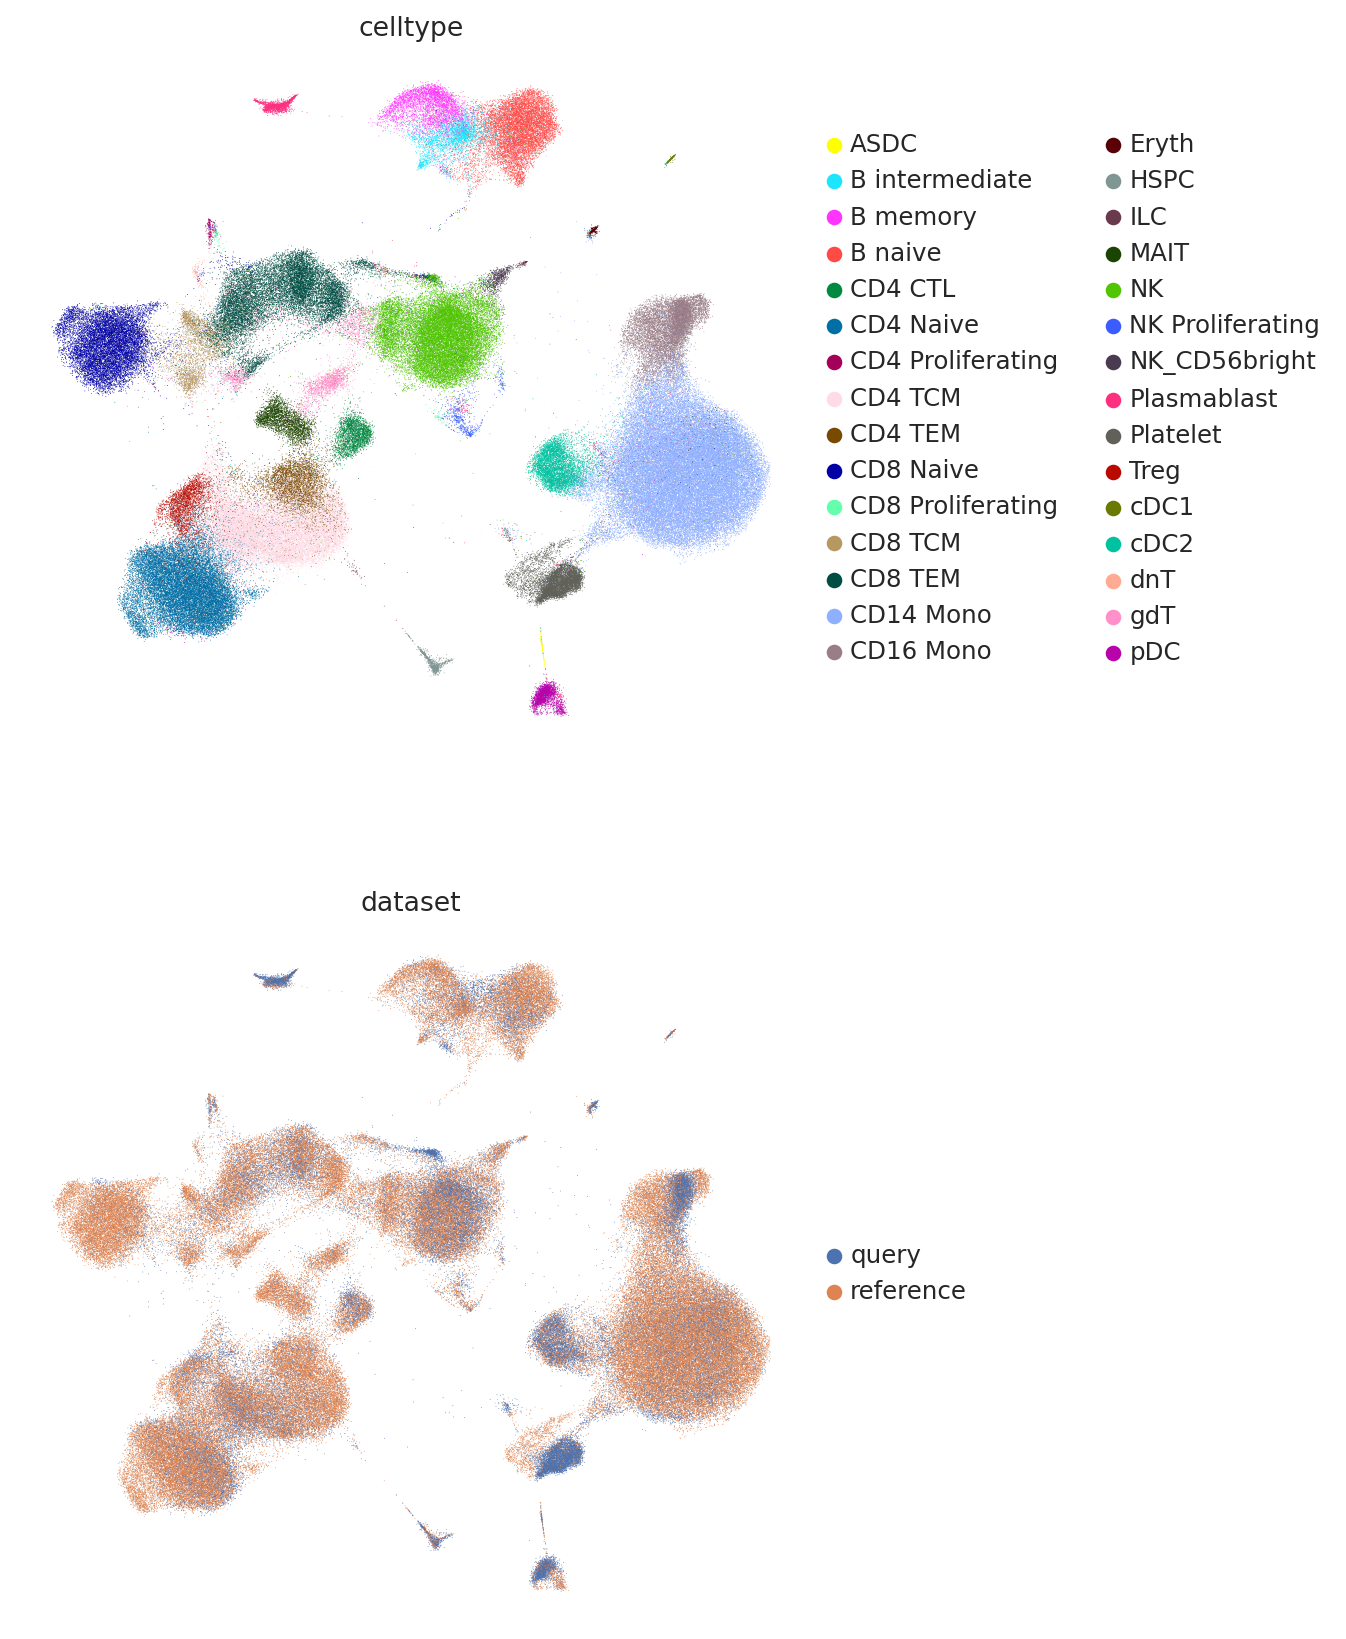

In [28]:
inds = np.random.permutation(np.arange(umap_adata.shape[0]))
sc.pl.umap(
    umap_adata[inds],
    color=["celltype", "dataset"],
    frameon=False,
    ncols=1,
)